In [2]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import pickle
import ast
import xarray as xr

In [3]:
#load and unpack data
with open("Data_A\\ReadyData_Synth_A.pkl", "rb") as f:
    data_dict = pickle.load(f)

cov_mat = data_dict['cov_mat']
grp_idx = data_dict['grp_idx']
obs_data = data_dict['resp']
params_fixed = data_dict['params_fixed']

In [4]:
exec(open("Build_Model_A.py").read())

model is built!


Add PSE and JND

In [5]:
with model_A:
    trace = pm.sample(return_inferencedata=True, chains = 4, cores=1, progressbar=True, idata_kwargs={"log_likelihood": True})   
print("FINISHED SAMPLING!")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [z_beta, z_gam_h, z_gam_l]


 |█████████████| 100.00% [2000/2000 02:23<00:00 Sampling chain 3, 0 divergences]

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 470 seconds.


FINISHED SAMPLING!


Look at r_hats and effective sample sizes, looks good

In [6]:
az.summary(trace, var_names = ['beta_vec', 'gam_h', 'gam_l', 'PSE', 'JND'])

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
beta_vec[b0, left_uni]  -1.025  0.106  -1.222  ...    3314.0    2759.0    1.0
beta_vec[b0, left_bi]    1.040  0.094   0.871  ...    4096.0    2887.0    1.0
beta_vec[b0, right_uni] -1.132  0.166  -1.435  ...    3282.0    2405.0    1.0
beta_vec[b0, right_bi]   1.061  0.131   0.834  ...    3913.0    3318.0    1.0
beta_vec[b1, left_uni]   3.261  0.197   2.897  ...    2869.0    2667.0    1.0
beta_vec[b1, left_bi]    3.029  0.199   2.681  ...    2630.0    2146.0    1.0
beta_vec[b1, right_uni]  6.199  0.453   5.369  ...    3165.0    2298.0    1.0
beta_vec[b1, right_bi]   6.623  0.422   5.852  ...    3821.0    2941.0    1.0
gam_h[left_uni]          0.033  0.007   0.019  ...    3719.0    2648.0    1.0
gam_h[left_bi]           0.053  0.017   0.021  ...    3271.0    1689.0    1.0
gam_h[right_uni]         0.059  0.007   0.046  ...    4631.0    3238.0    1.0
gam_h[right_bi]          0.033  0.006   0.022  ...    4214.0    2901.0    1.0
gam_l[left_uni]          0.015  0.009   0.000  ...    3282.0    1805.0    1.0
gam_l[left_bi]           0.012  0.005   0.003  ...    3214.0    2369.0    1.0
gam_l[right_uni]         0.005  0.003   0.001  ...    3918.0    2342.0    1.0
gam_l[right_bi]          0.008  0.003   0.004  ...    4727.0    2579.0    1.0
PSE[left_uni]            0.303  0.022   0.262  ...    4482.0    3603.0    1.0
PSE[left_bi]            -0.373  0.025  -0.419  ...    4485.0    3053.0    1.0
PSE[right_uni]           0.163  0.018   0.127  ...    3694.0    3096.0    1.0
PSE[right_bi]           -0.168  0.016  -0.195  ...    5413.0    3696.0    1.0
JND[left_uni]            0.359  0.018   0.325  ...    3102.0    2891.0    1.0
JND[left_bi]             0.398  0.020   0.358  ...    3106.0    2396.0    1.0
JND[right_uni]           0.194  0.013   0.170  ...    3375.0    2731.0    1.0
JND[right_bi]            0.175  0.011   0.156  ...    3980.0    2910.0    1.0

[24 rows x 9 columns]

Look at joint posteriors for parameters. Some identifiability issues.

In [7]:
grp_num = 0
grp_choice = coords['groups'][grp_num]

param_bases = ['gam_h ', 'gam_l ','beta_vec b0, ','beta_vec b1, ']
ref_vals = {}

for grp_num, grp_choice in enumerate(coords['groups']):
    temp_dict = {}
    for par_num, par_base in enumerate(param_bases):
        temp_dict[par_base+grp_choice] = params_fixed[par_num][grp_num]
    ref_vals[grp_choice] = temp_dict

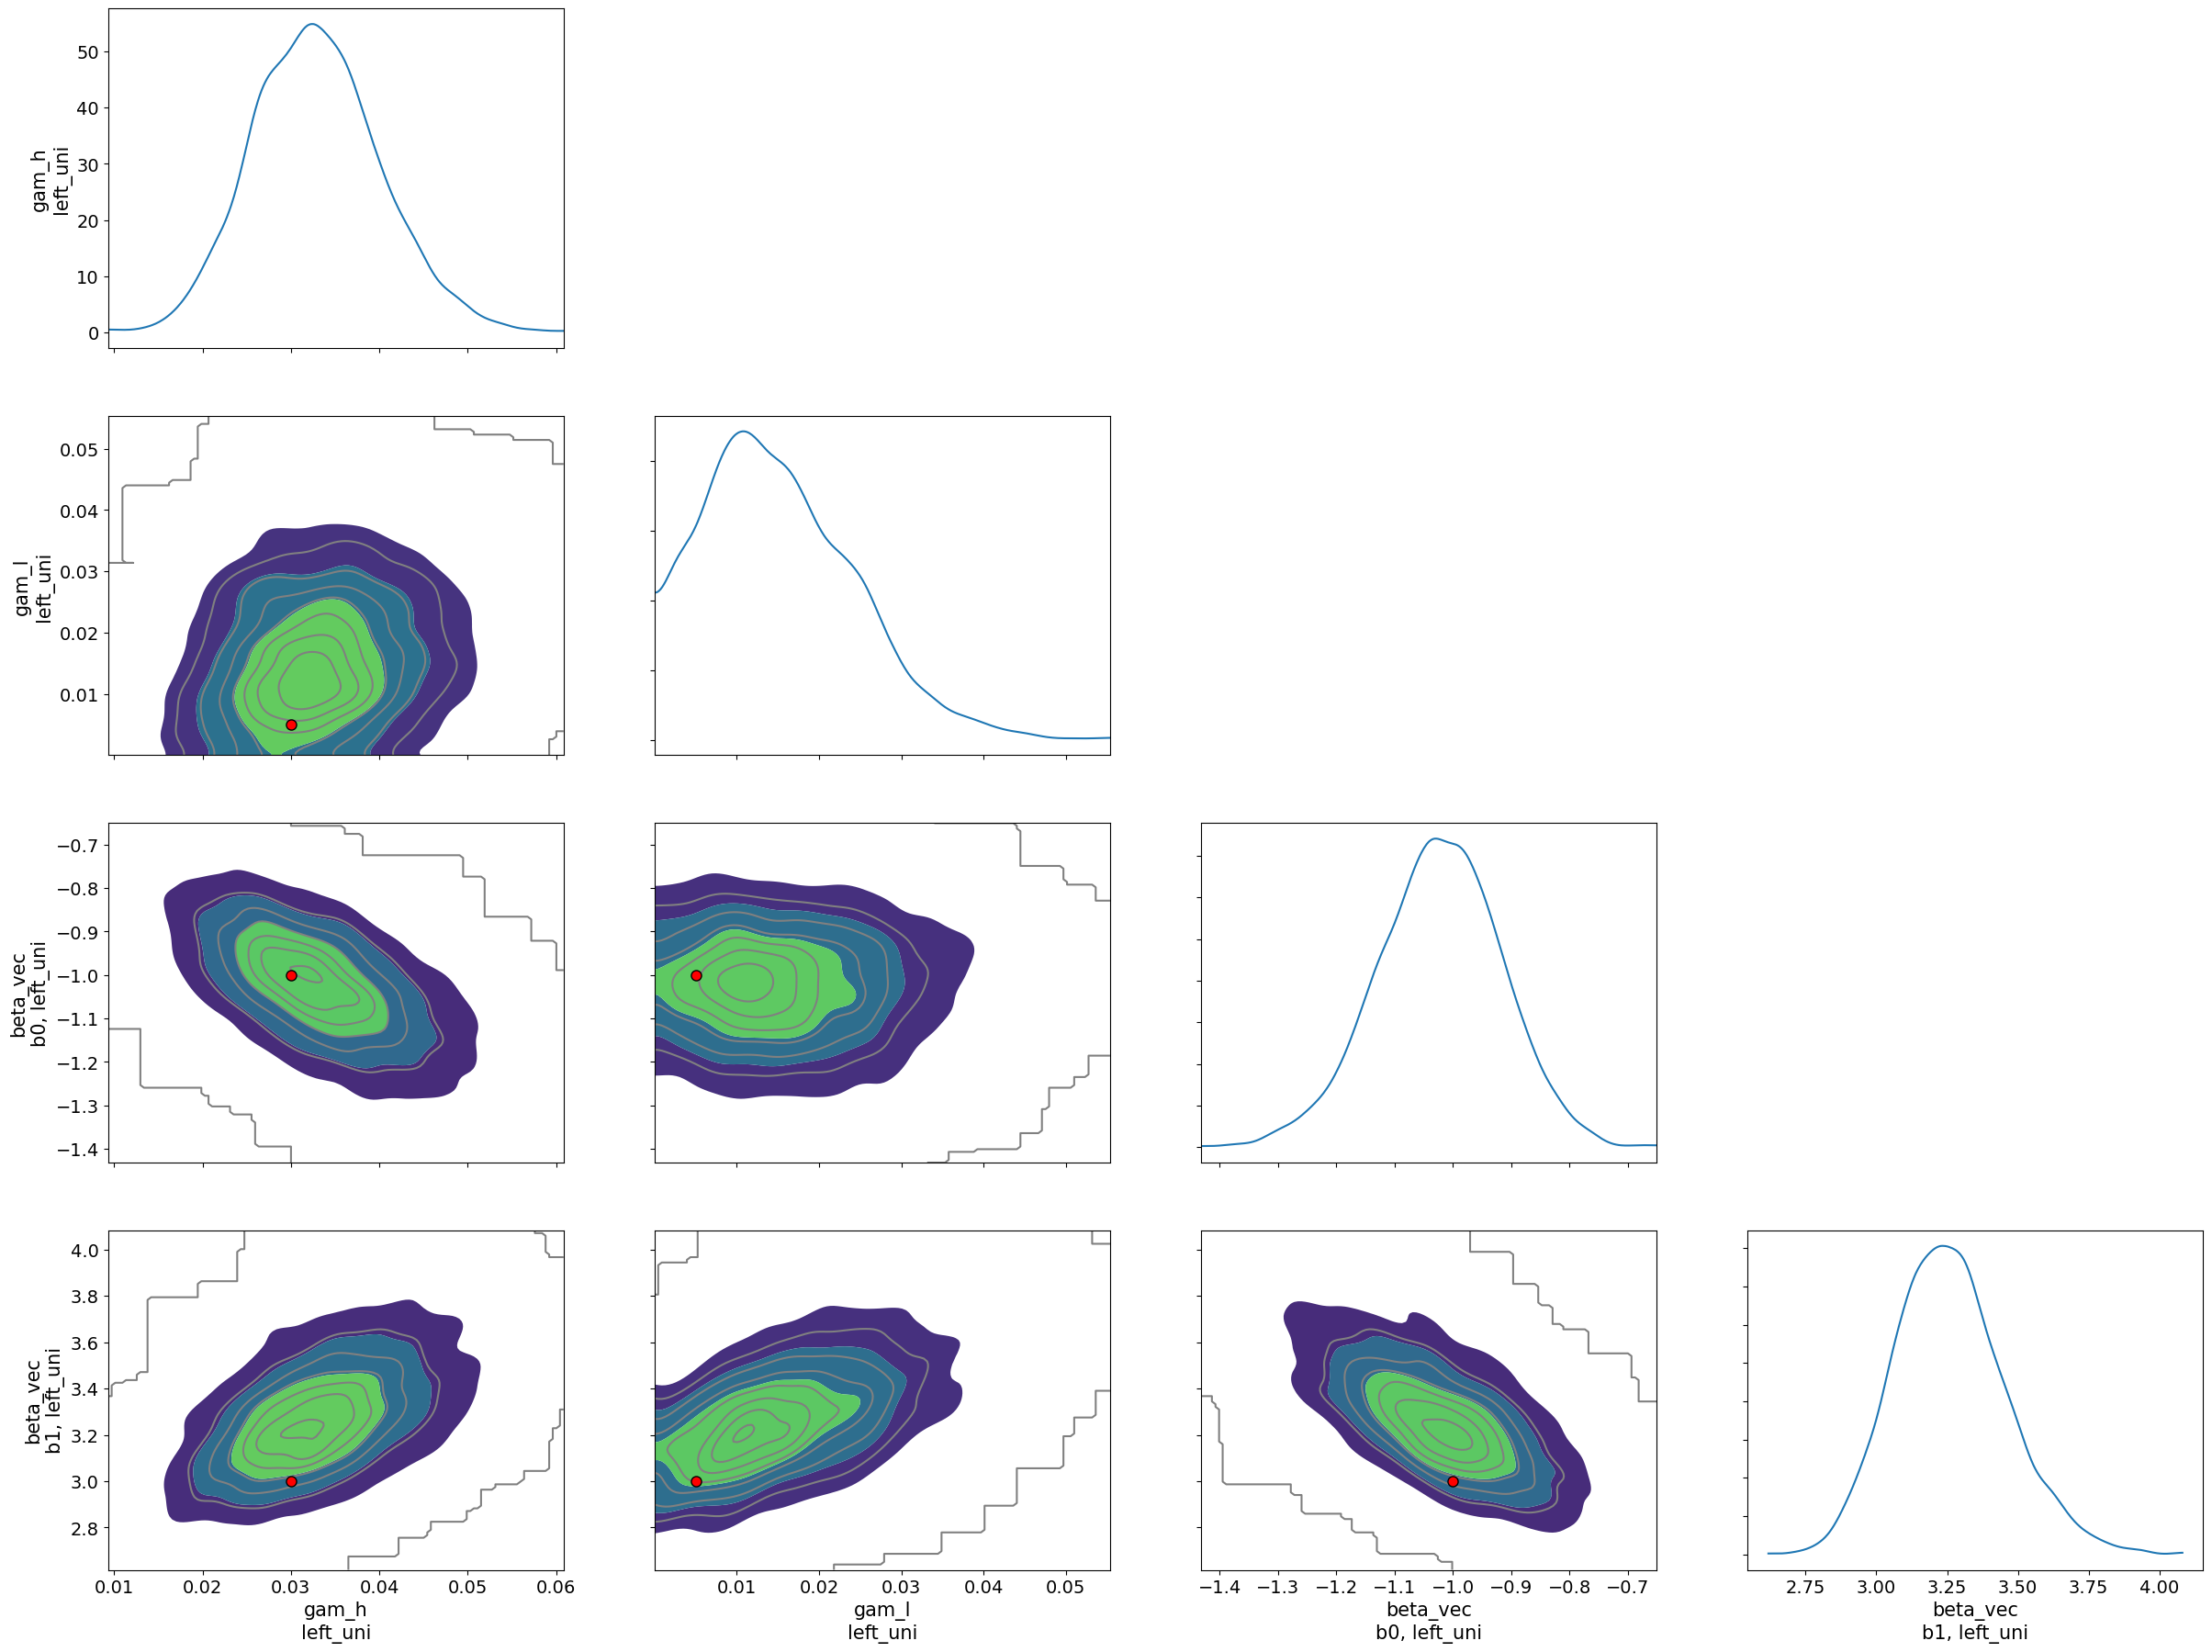

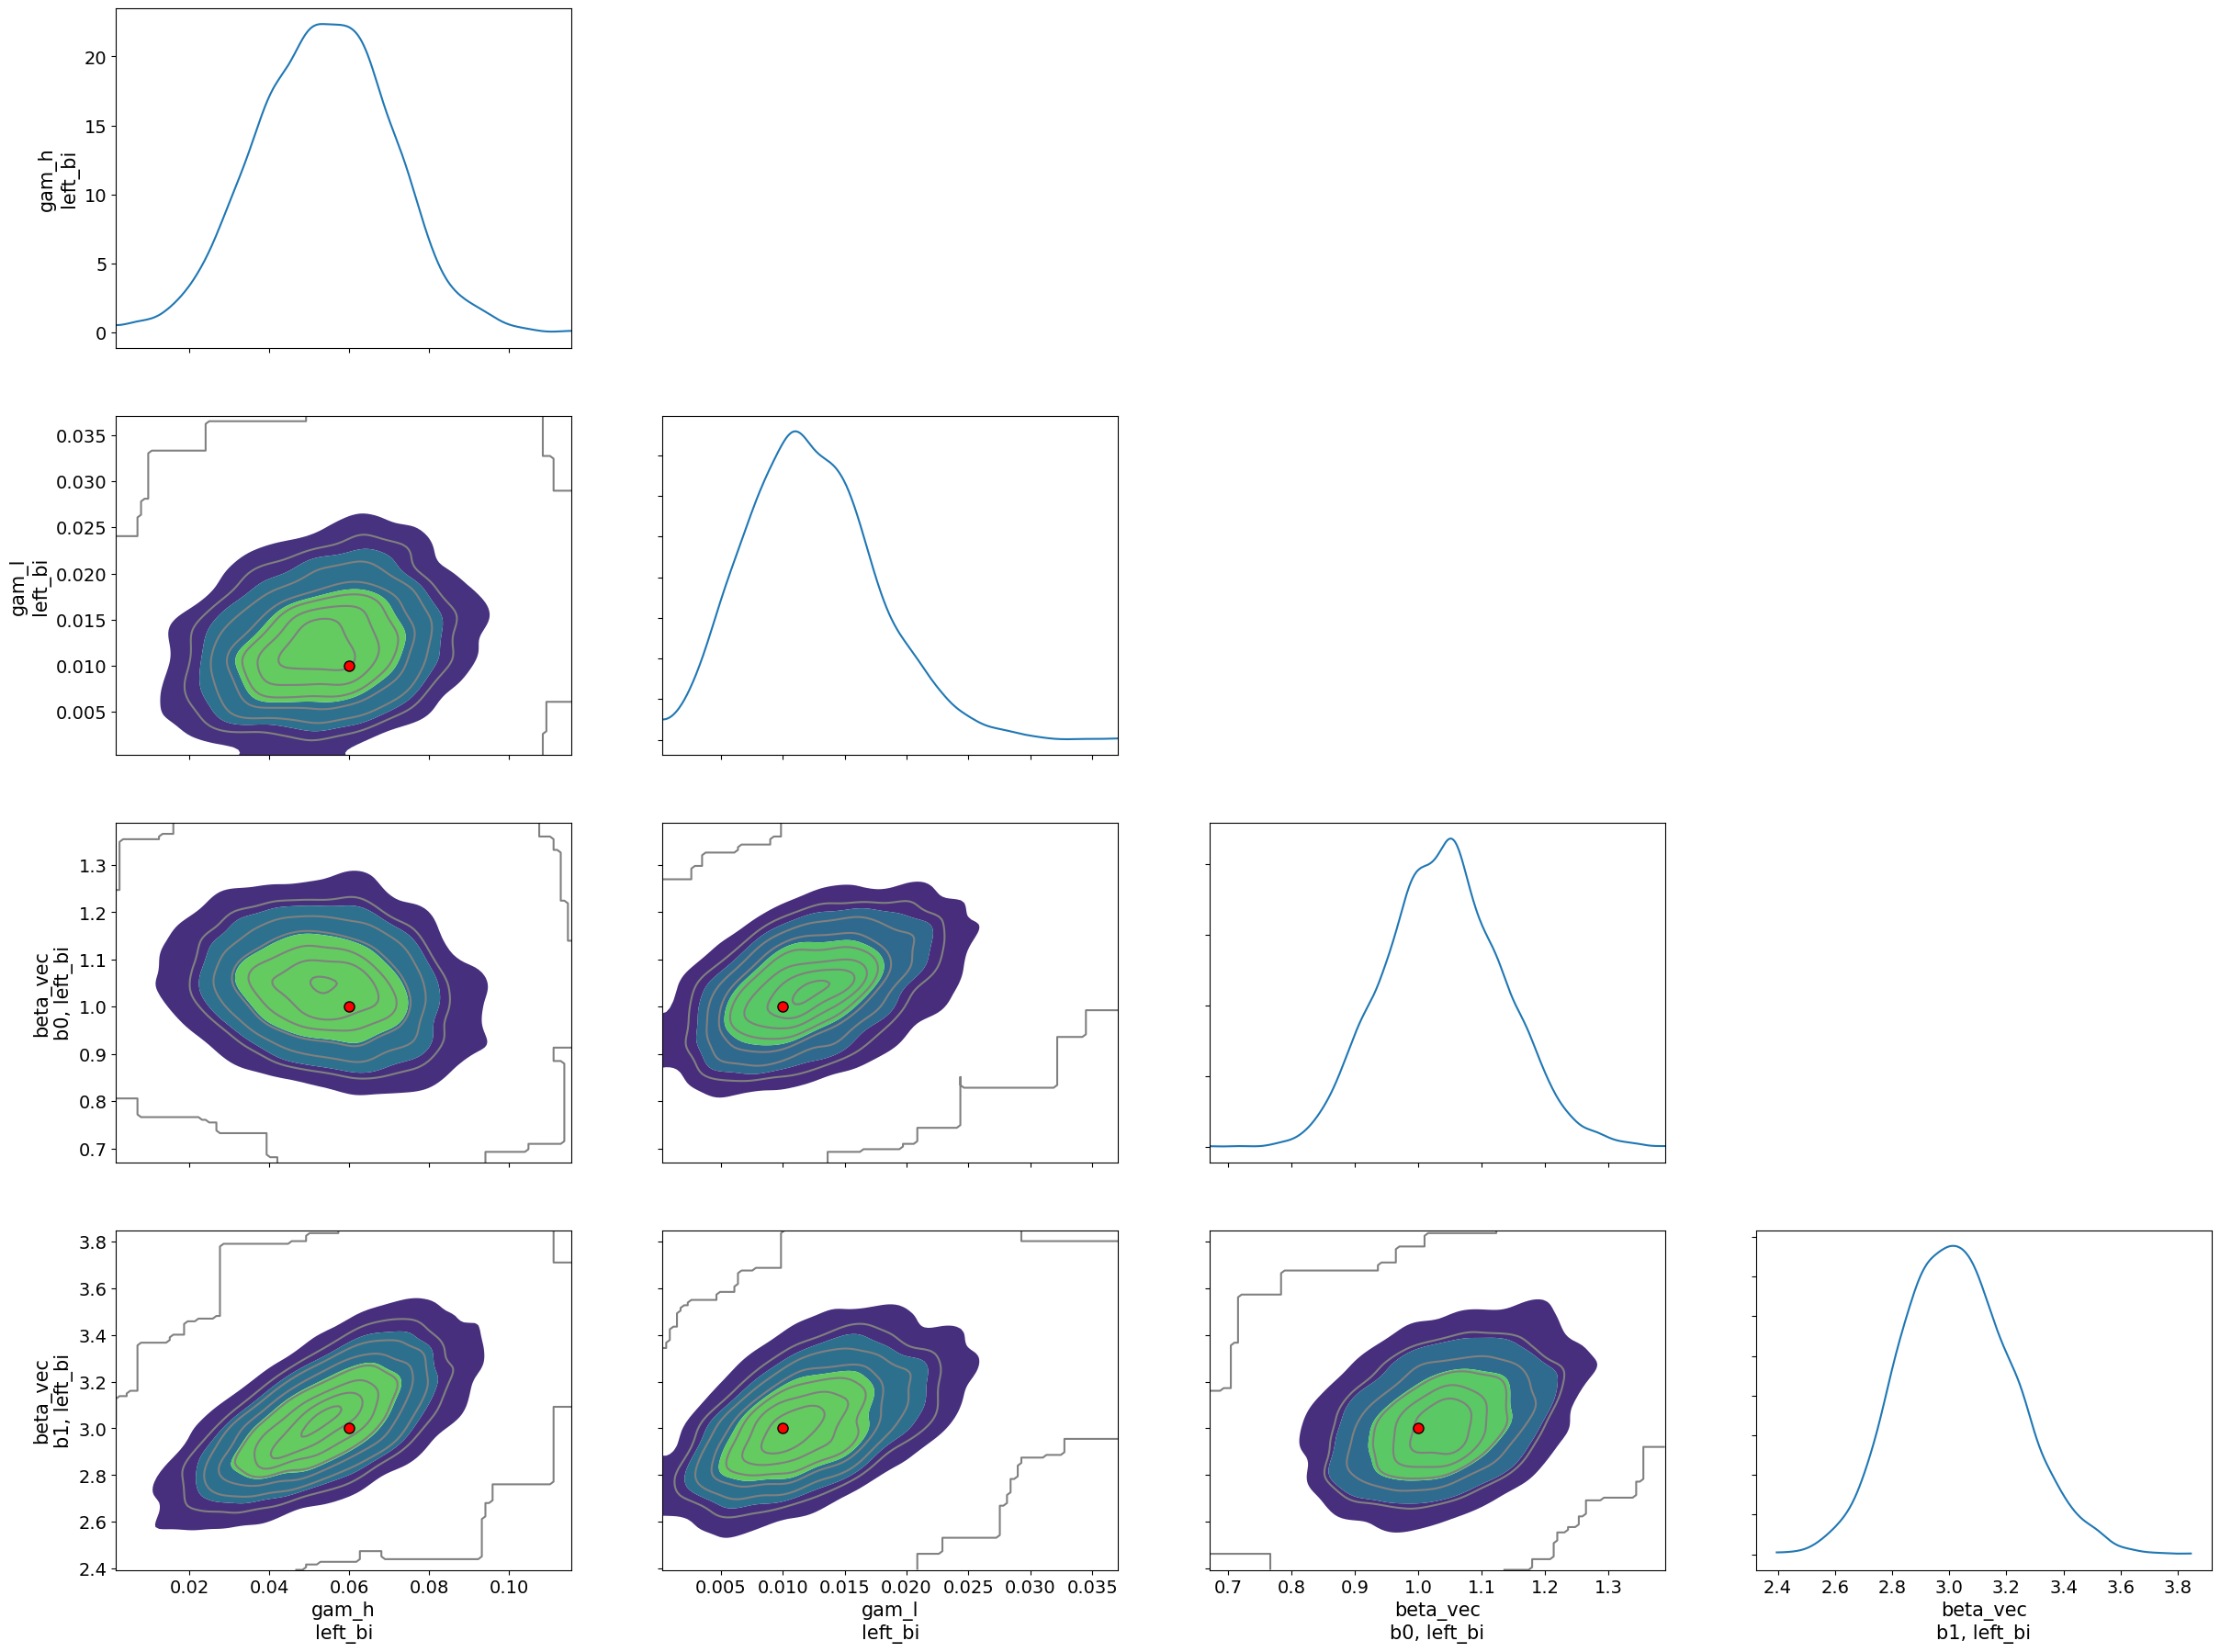

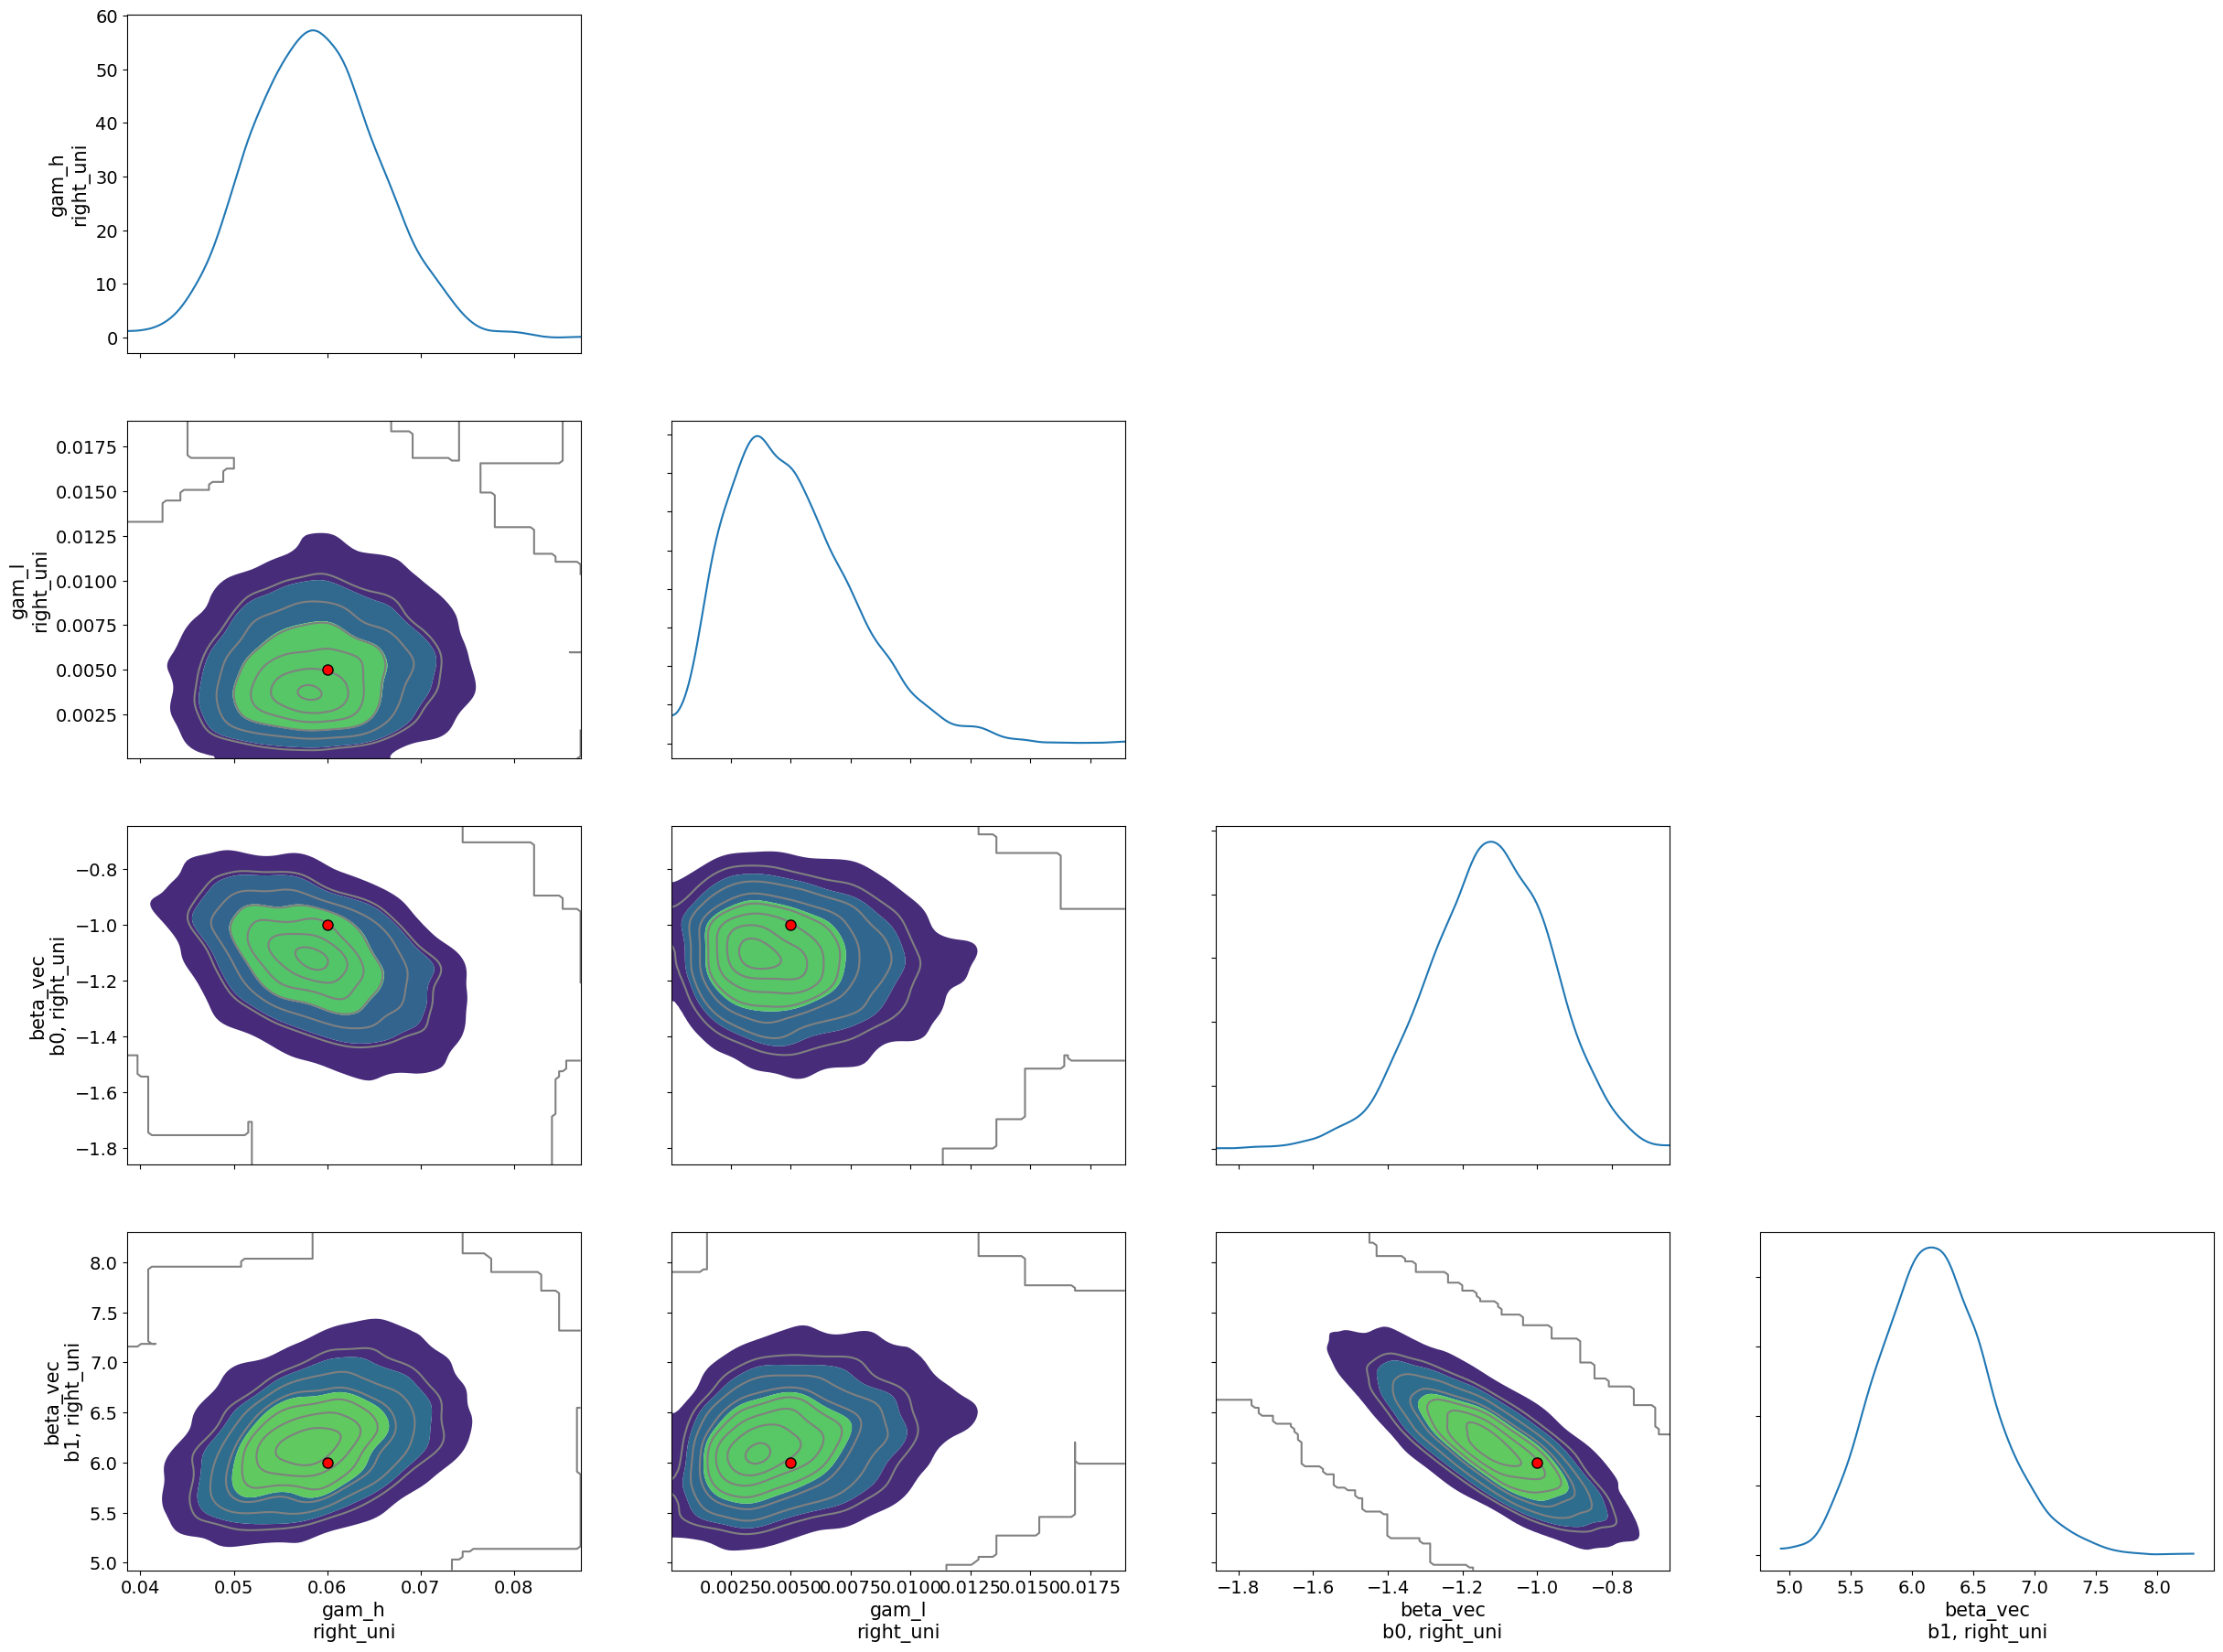

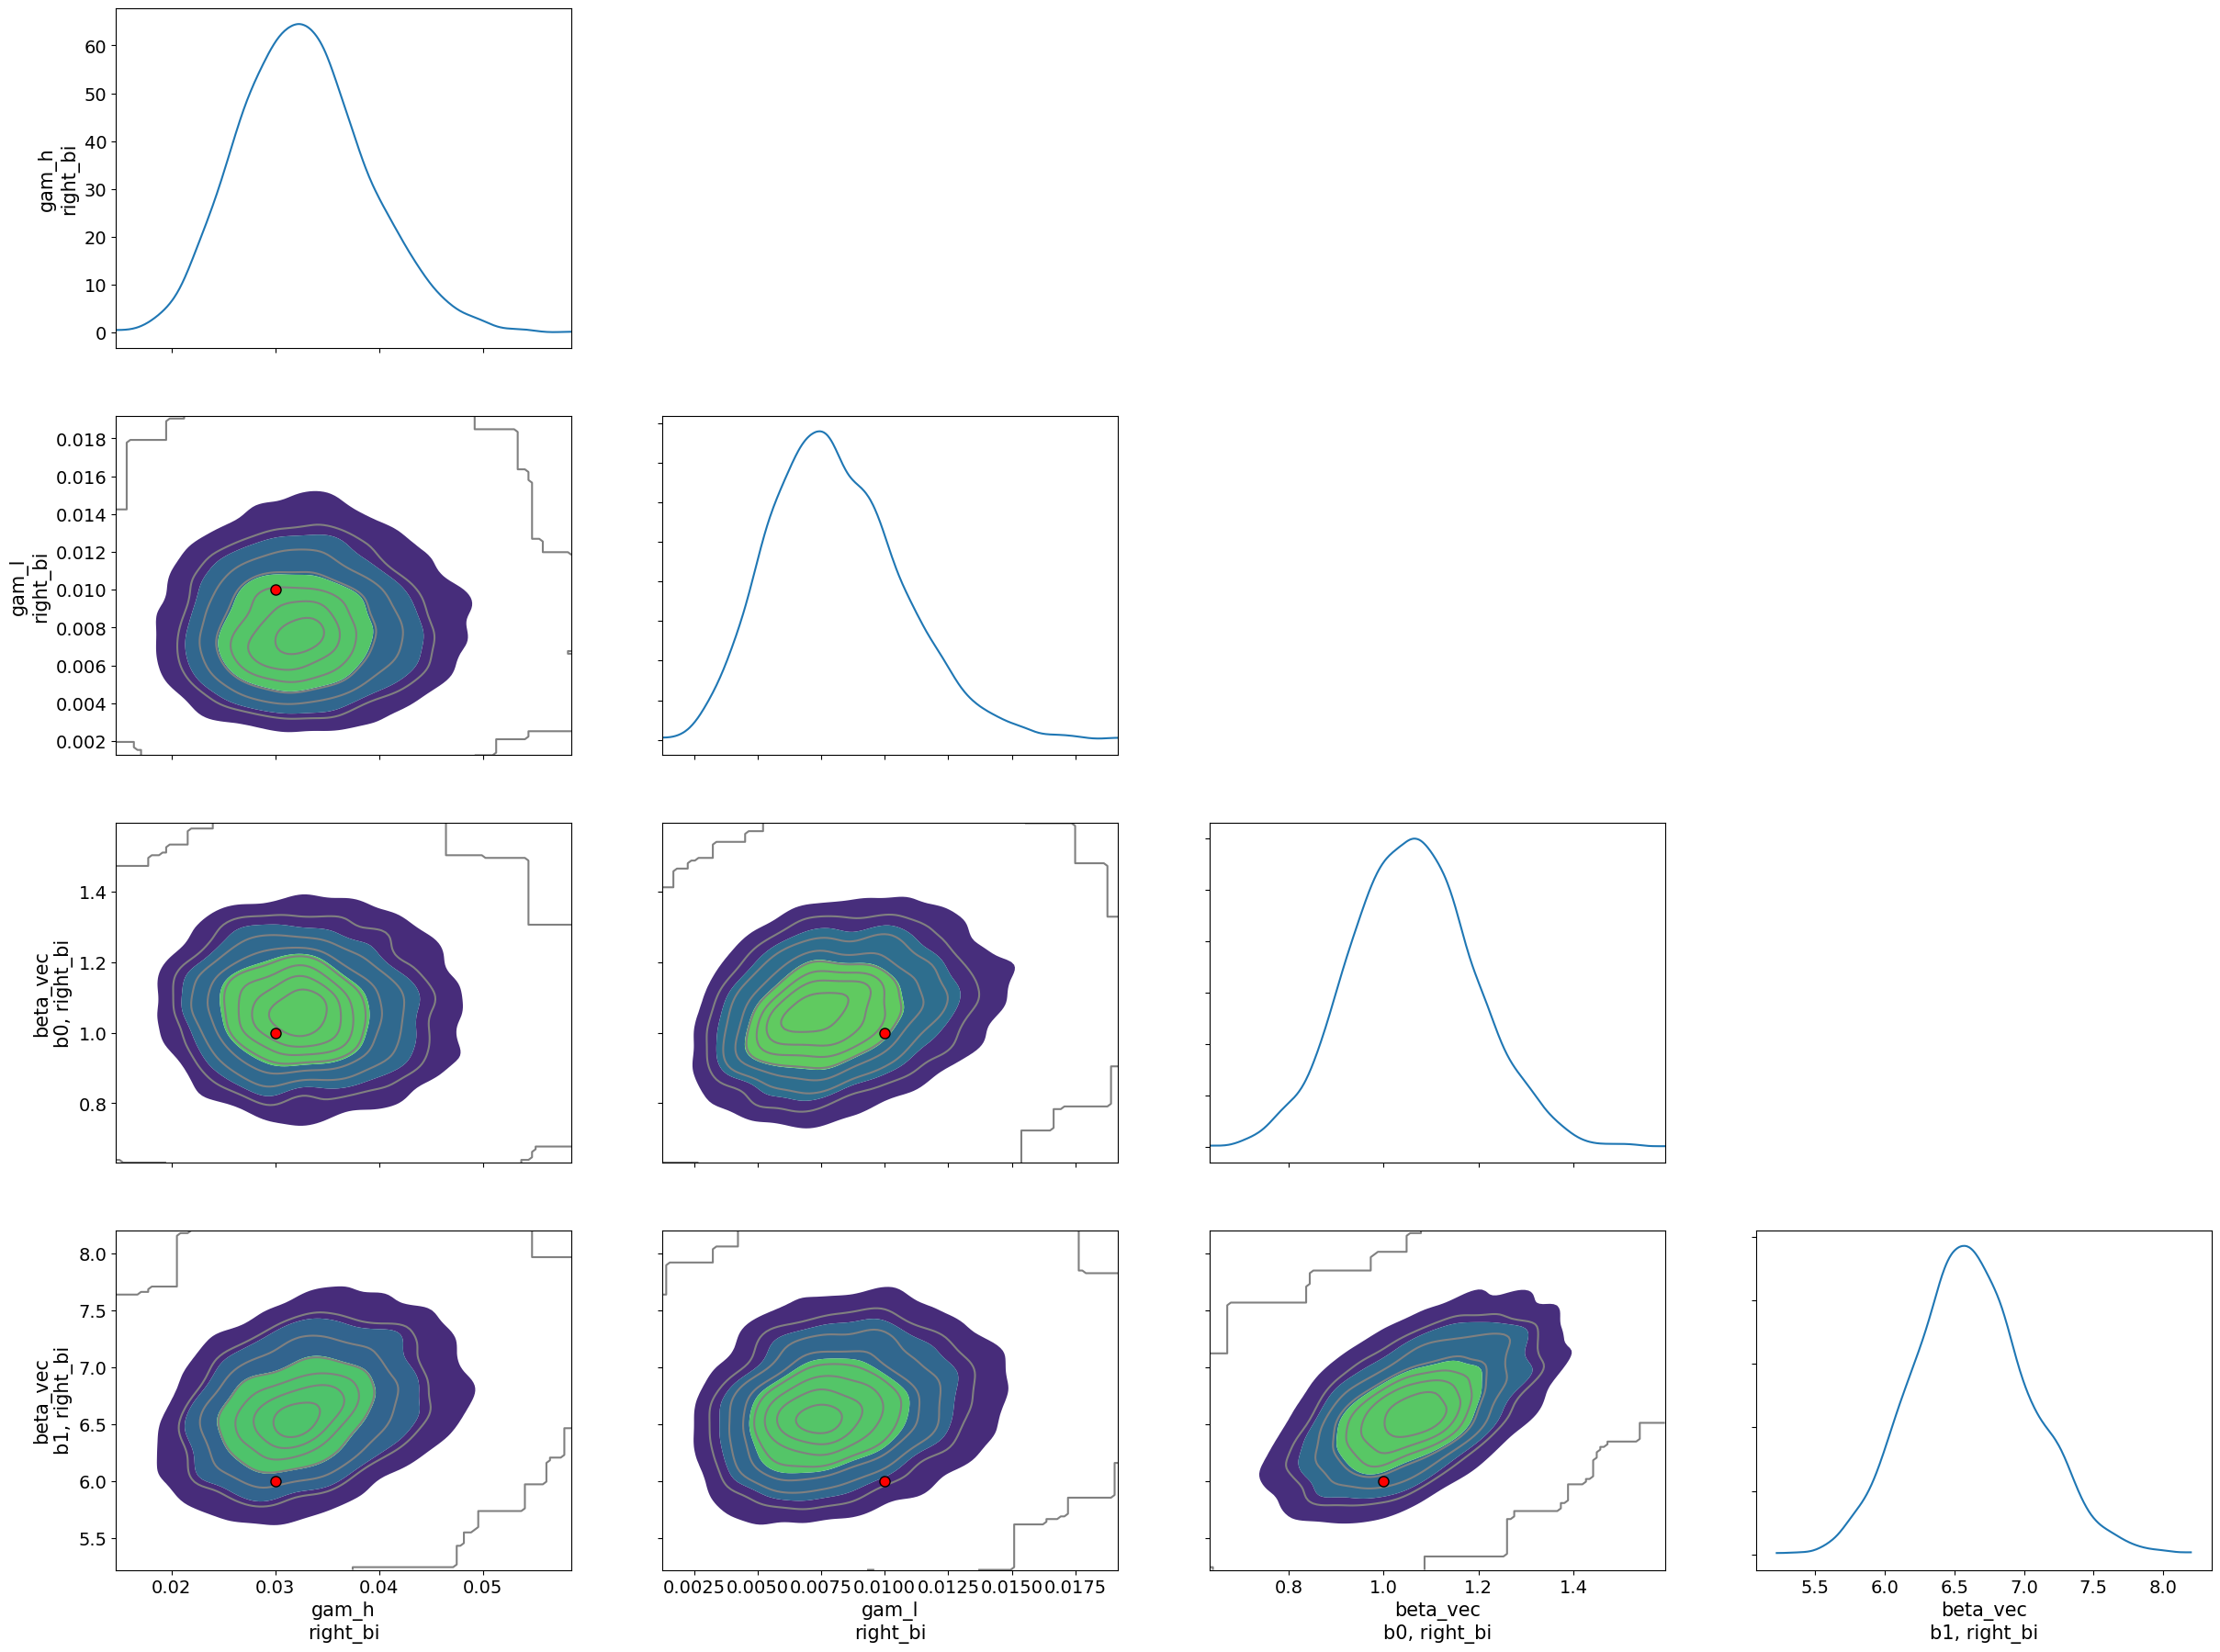

In [8]:
for grp_num, grp_choice in enumerate(coords['groups']):
     az.plot_pair(trace, var_names=['gam_h', 'gam_l', 'beta_vec'], 
             coords = {'betas': ["b0", "b1"], 'groups': [grp_choice]}, 
             reference_values = ref_vals[grp_choice],
                       reference_values_kwargs=dict(marker="o", color="red", markersize=8),
             kind = 'kde', marginals=True)

Look at joint posteriors for PSE and JND

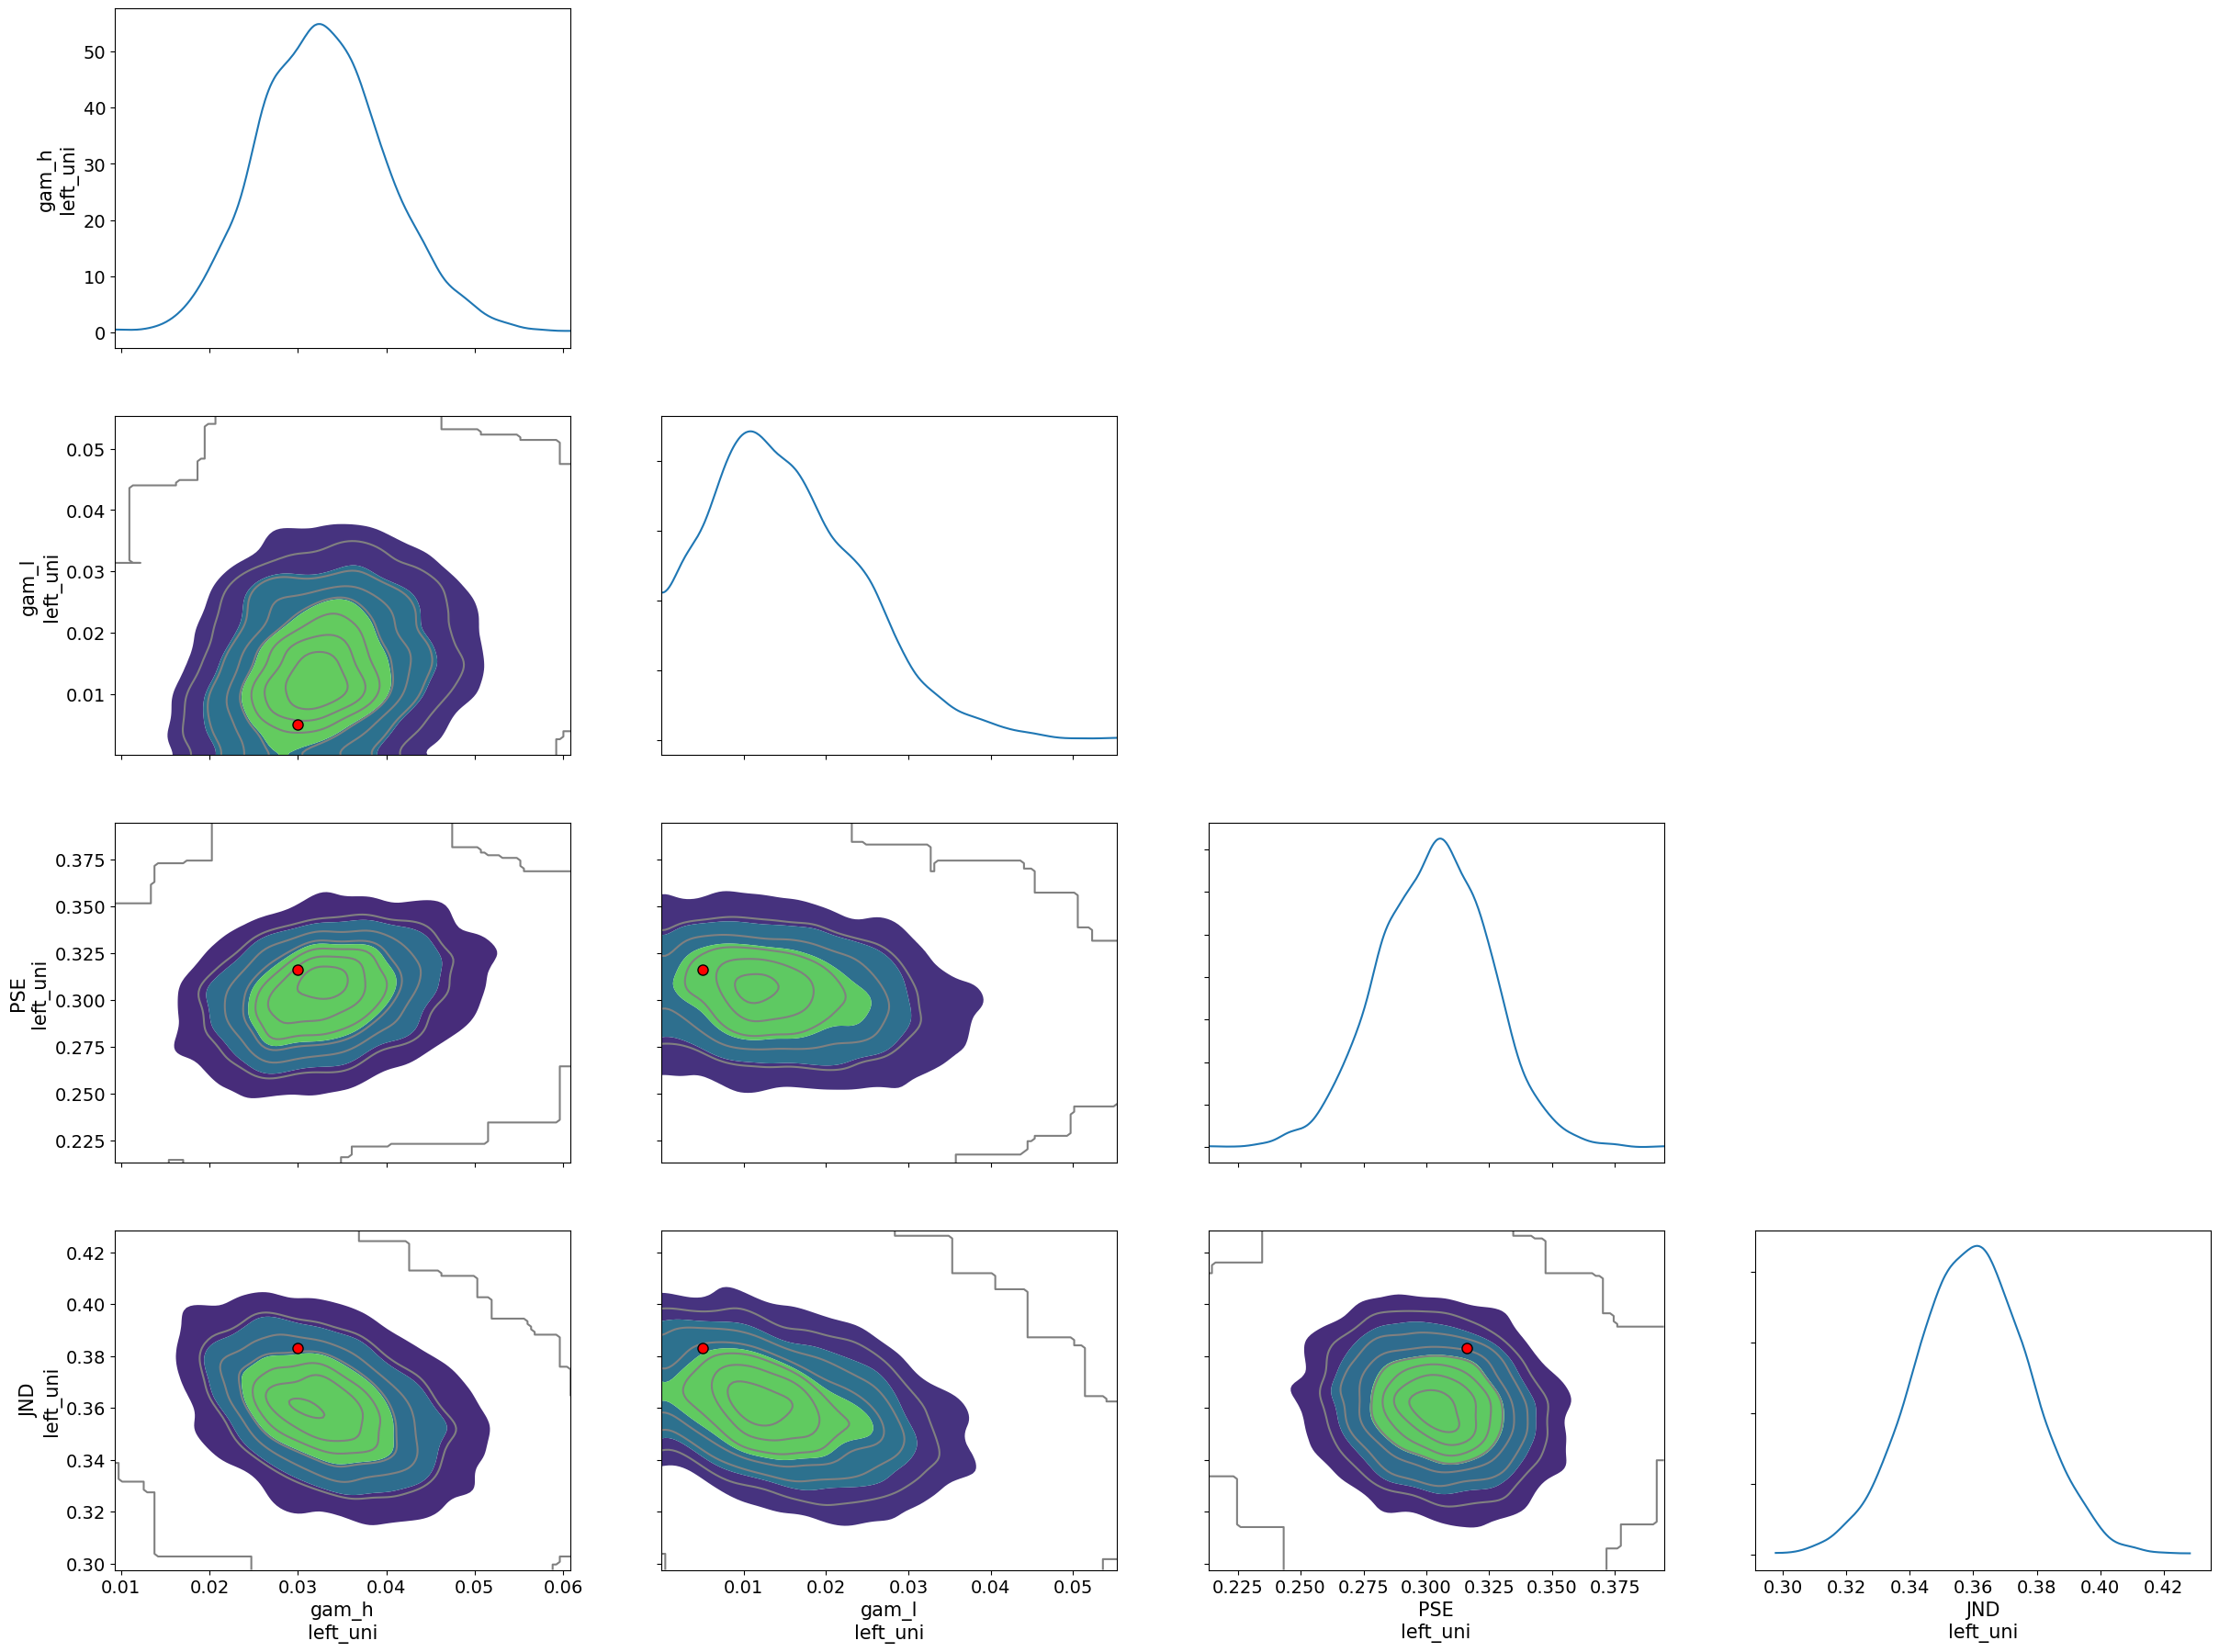

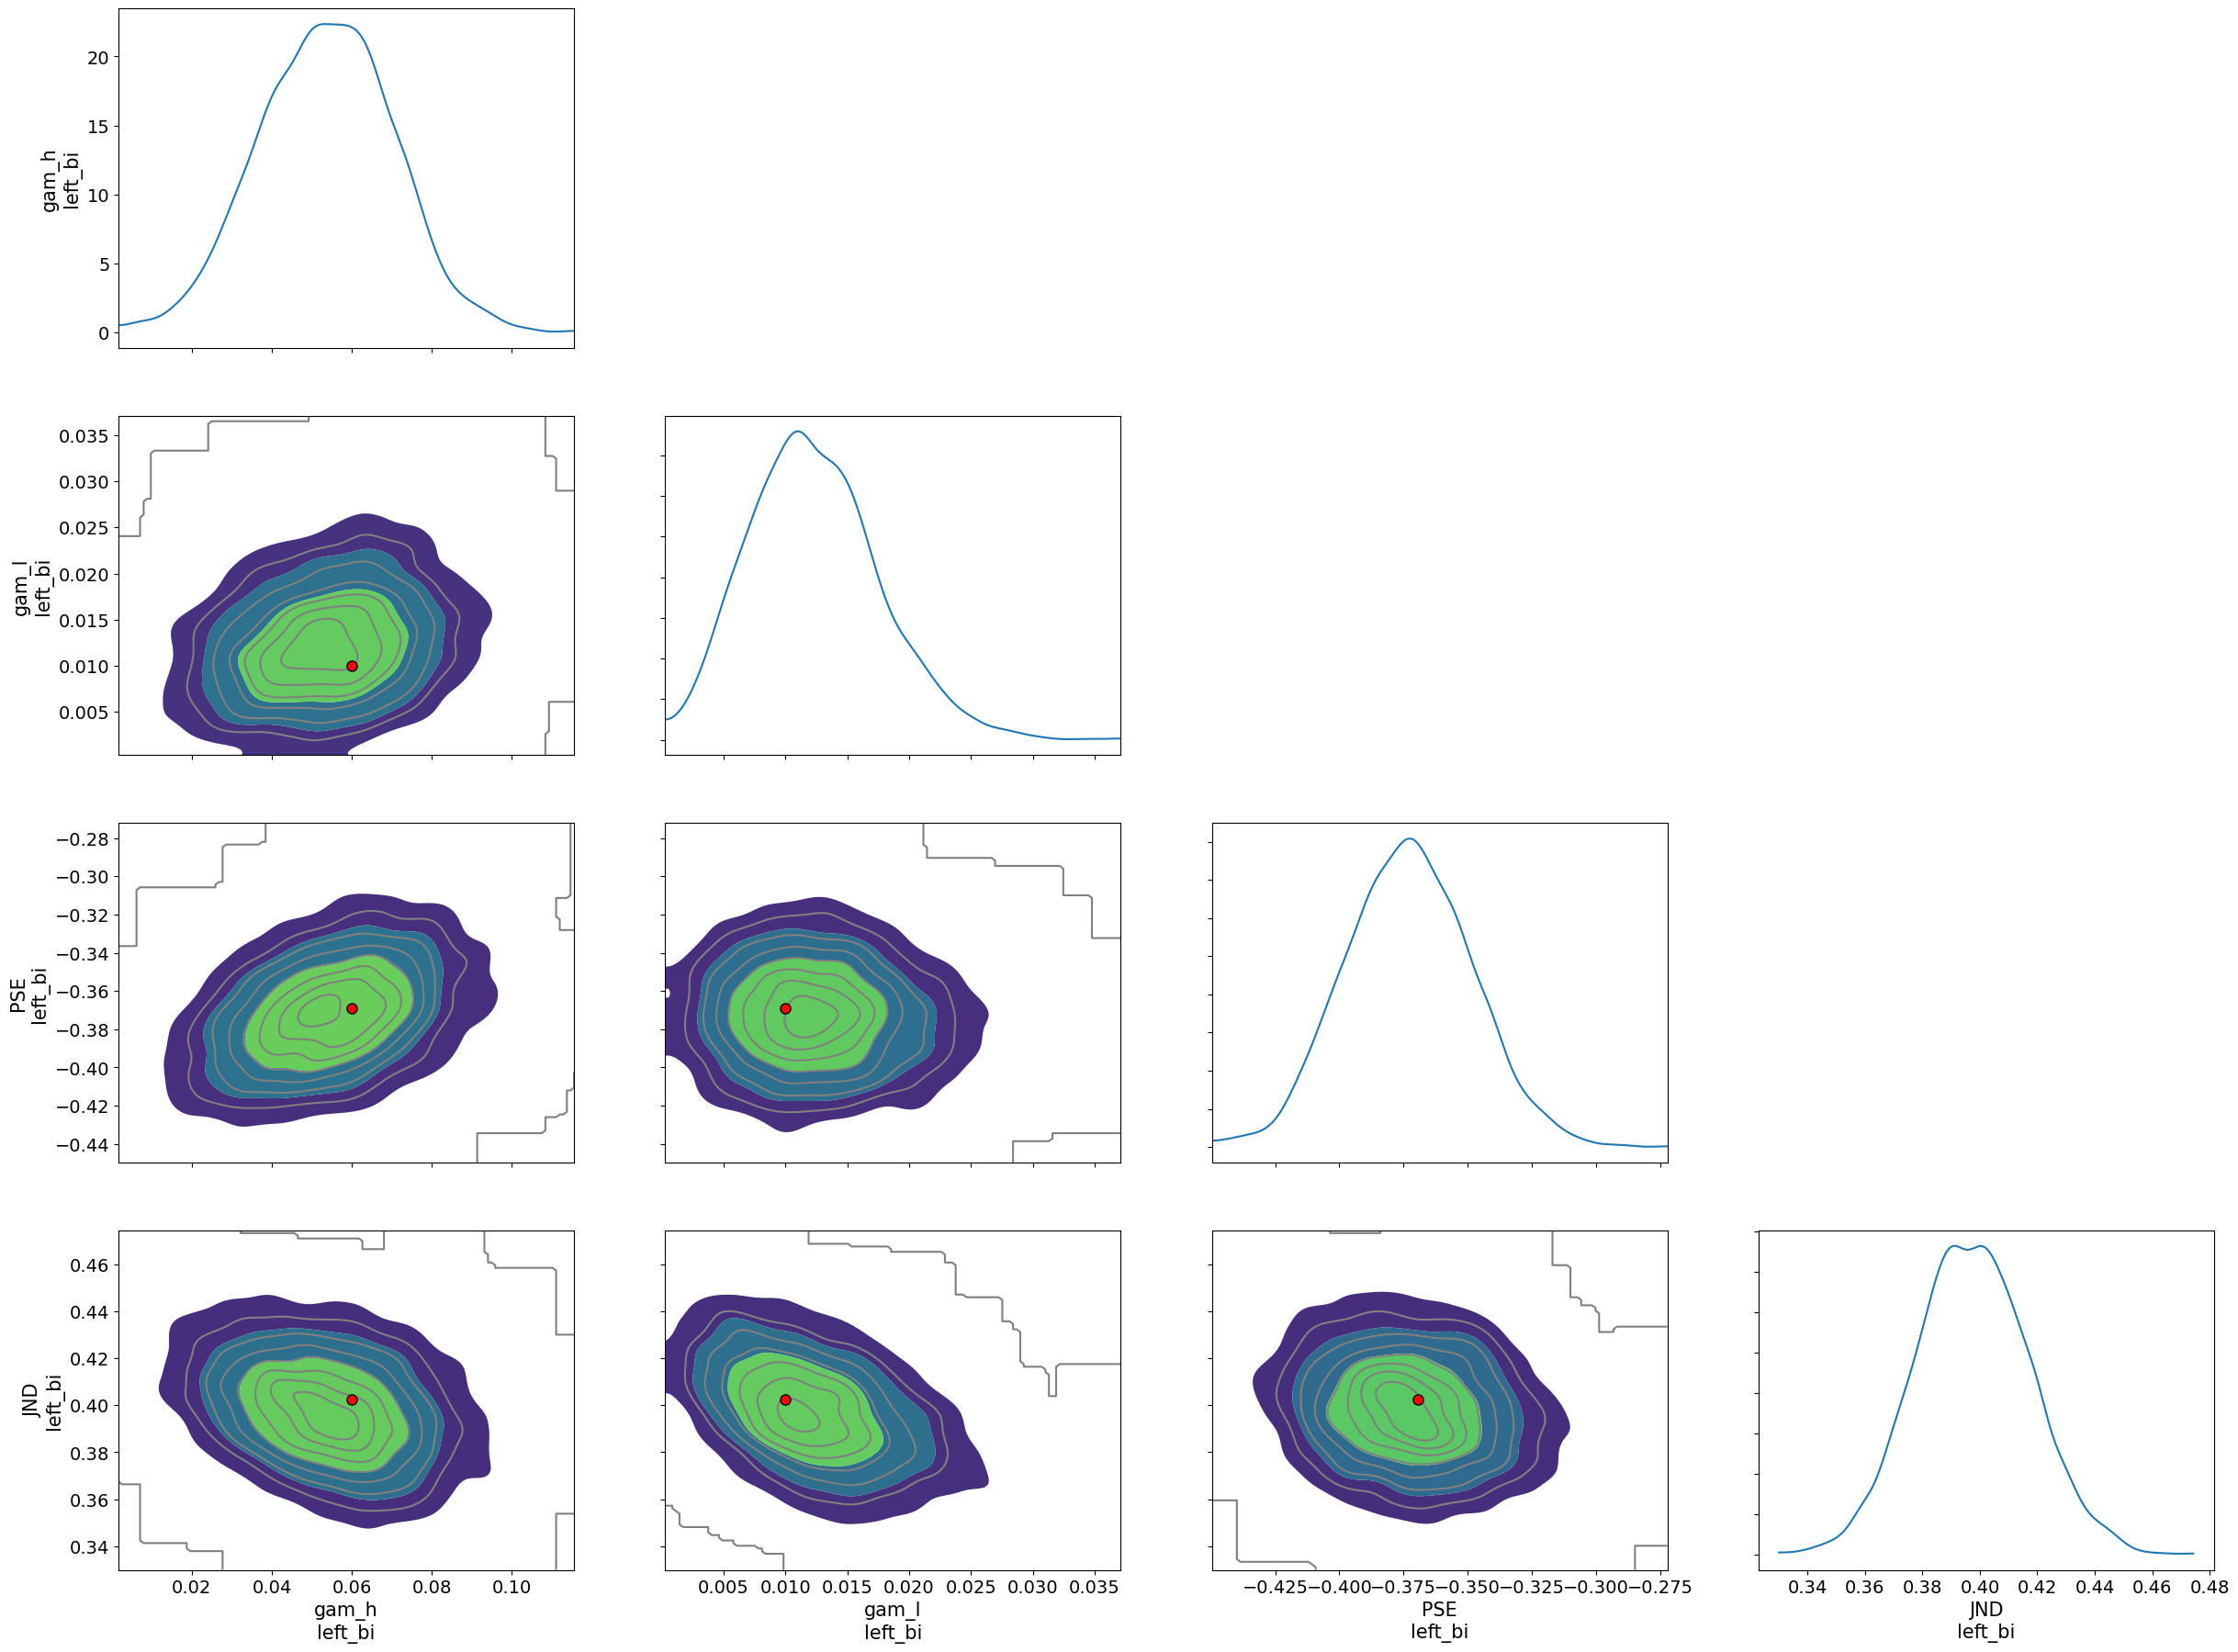

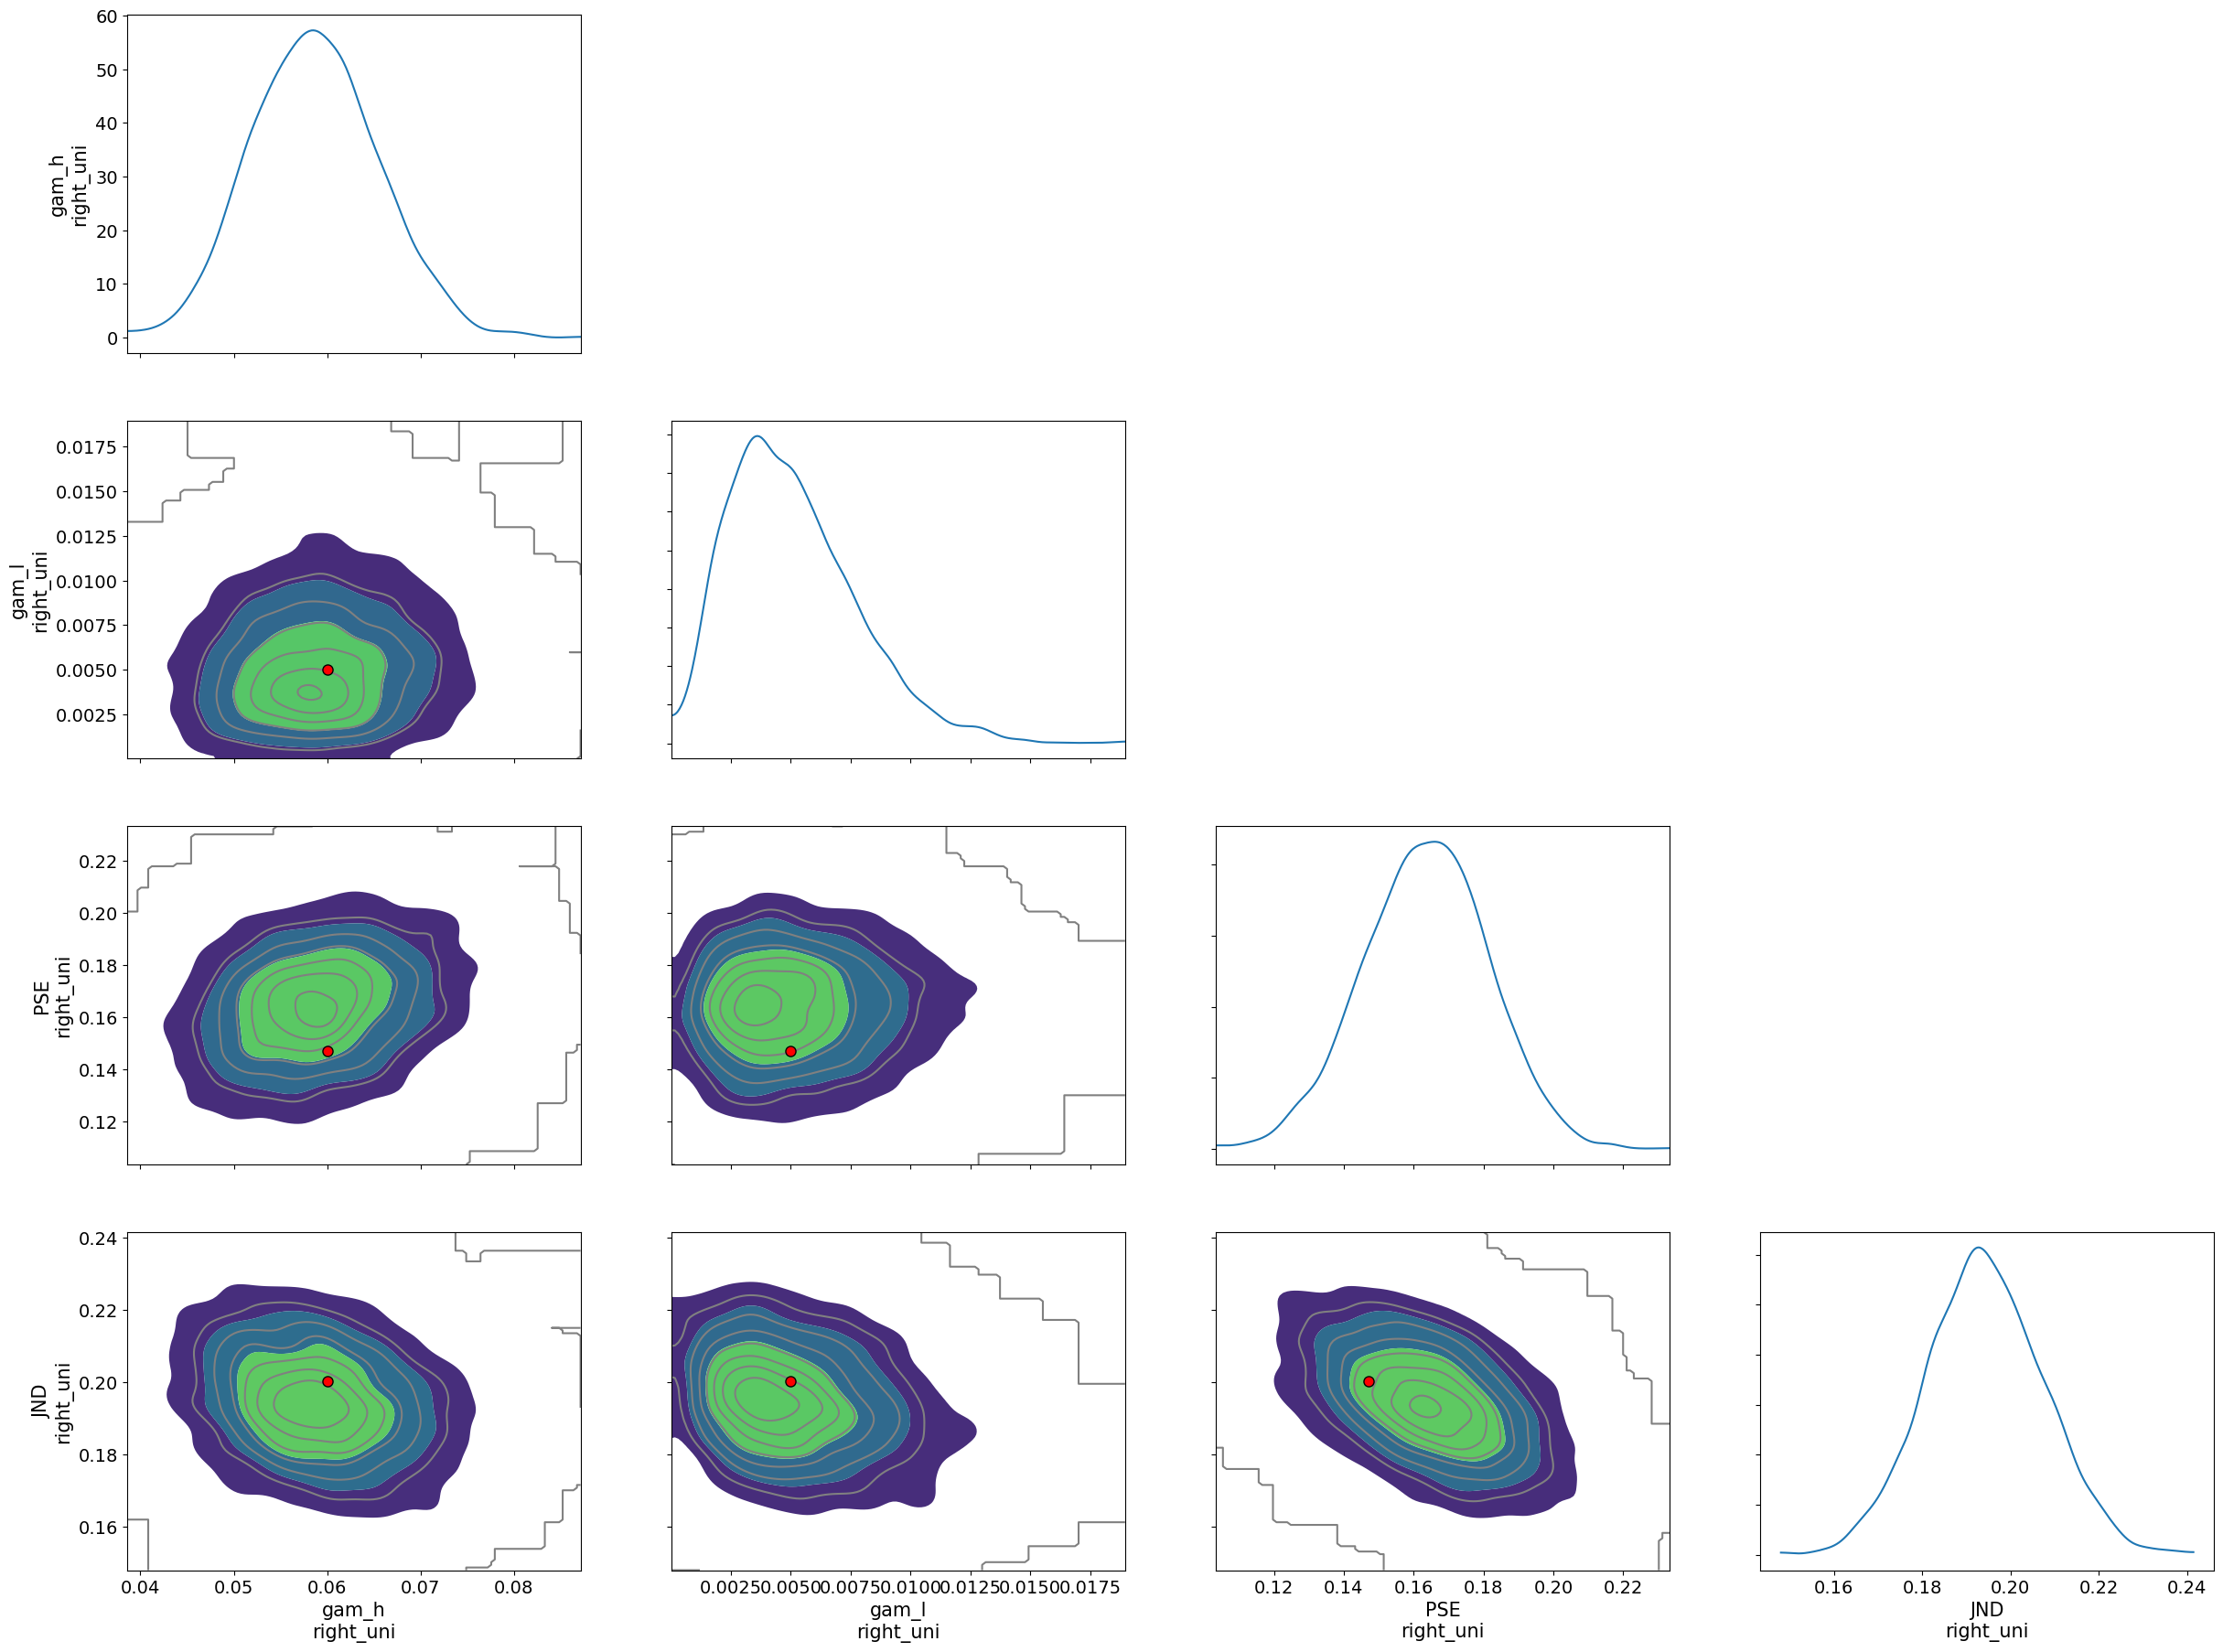

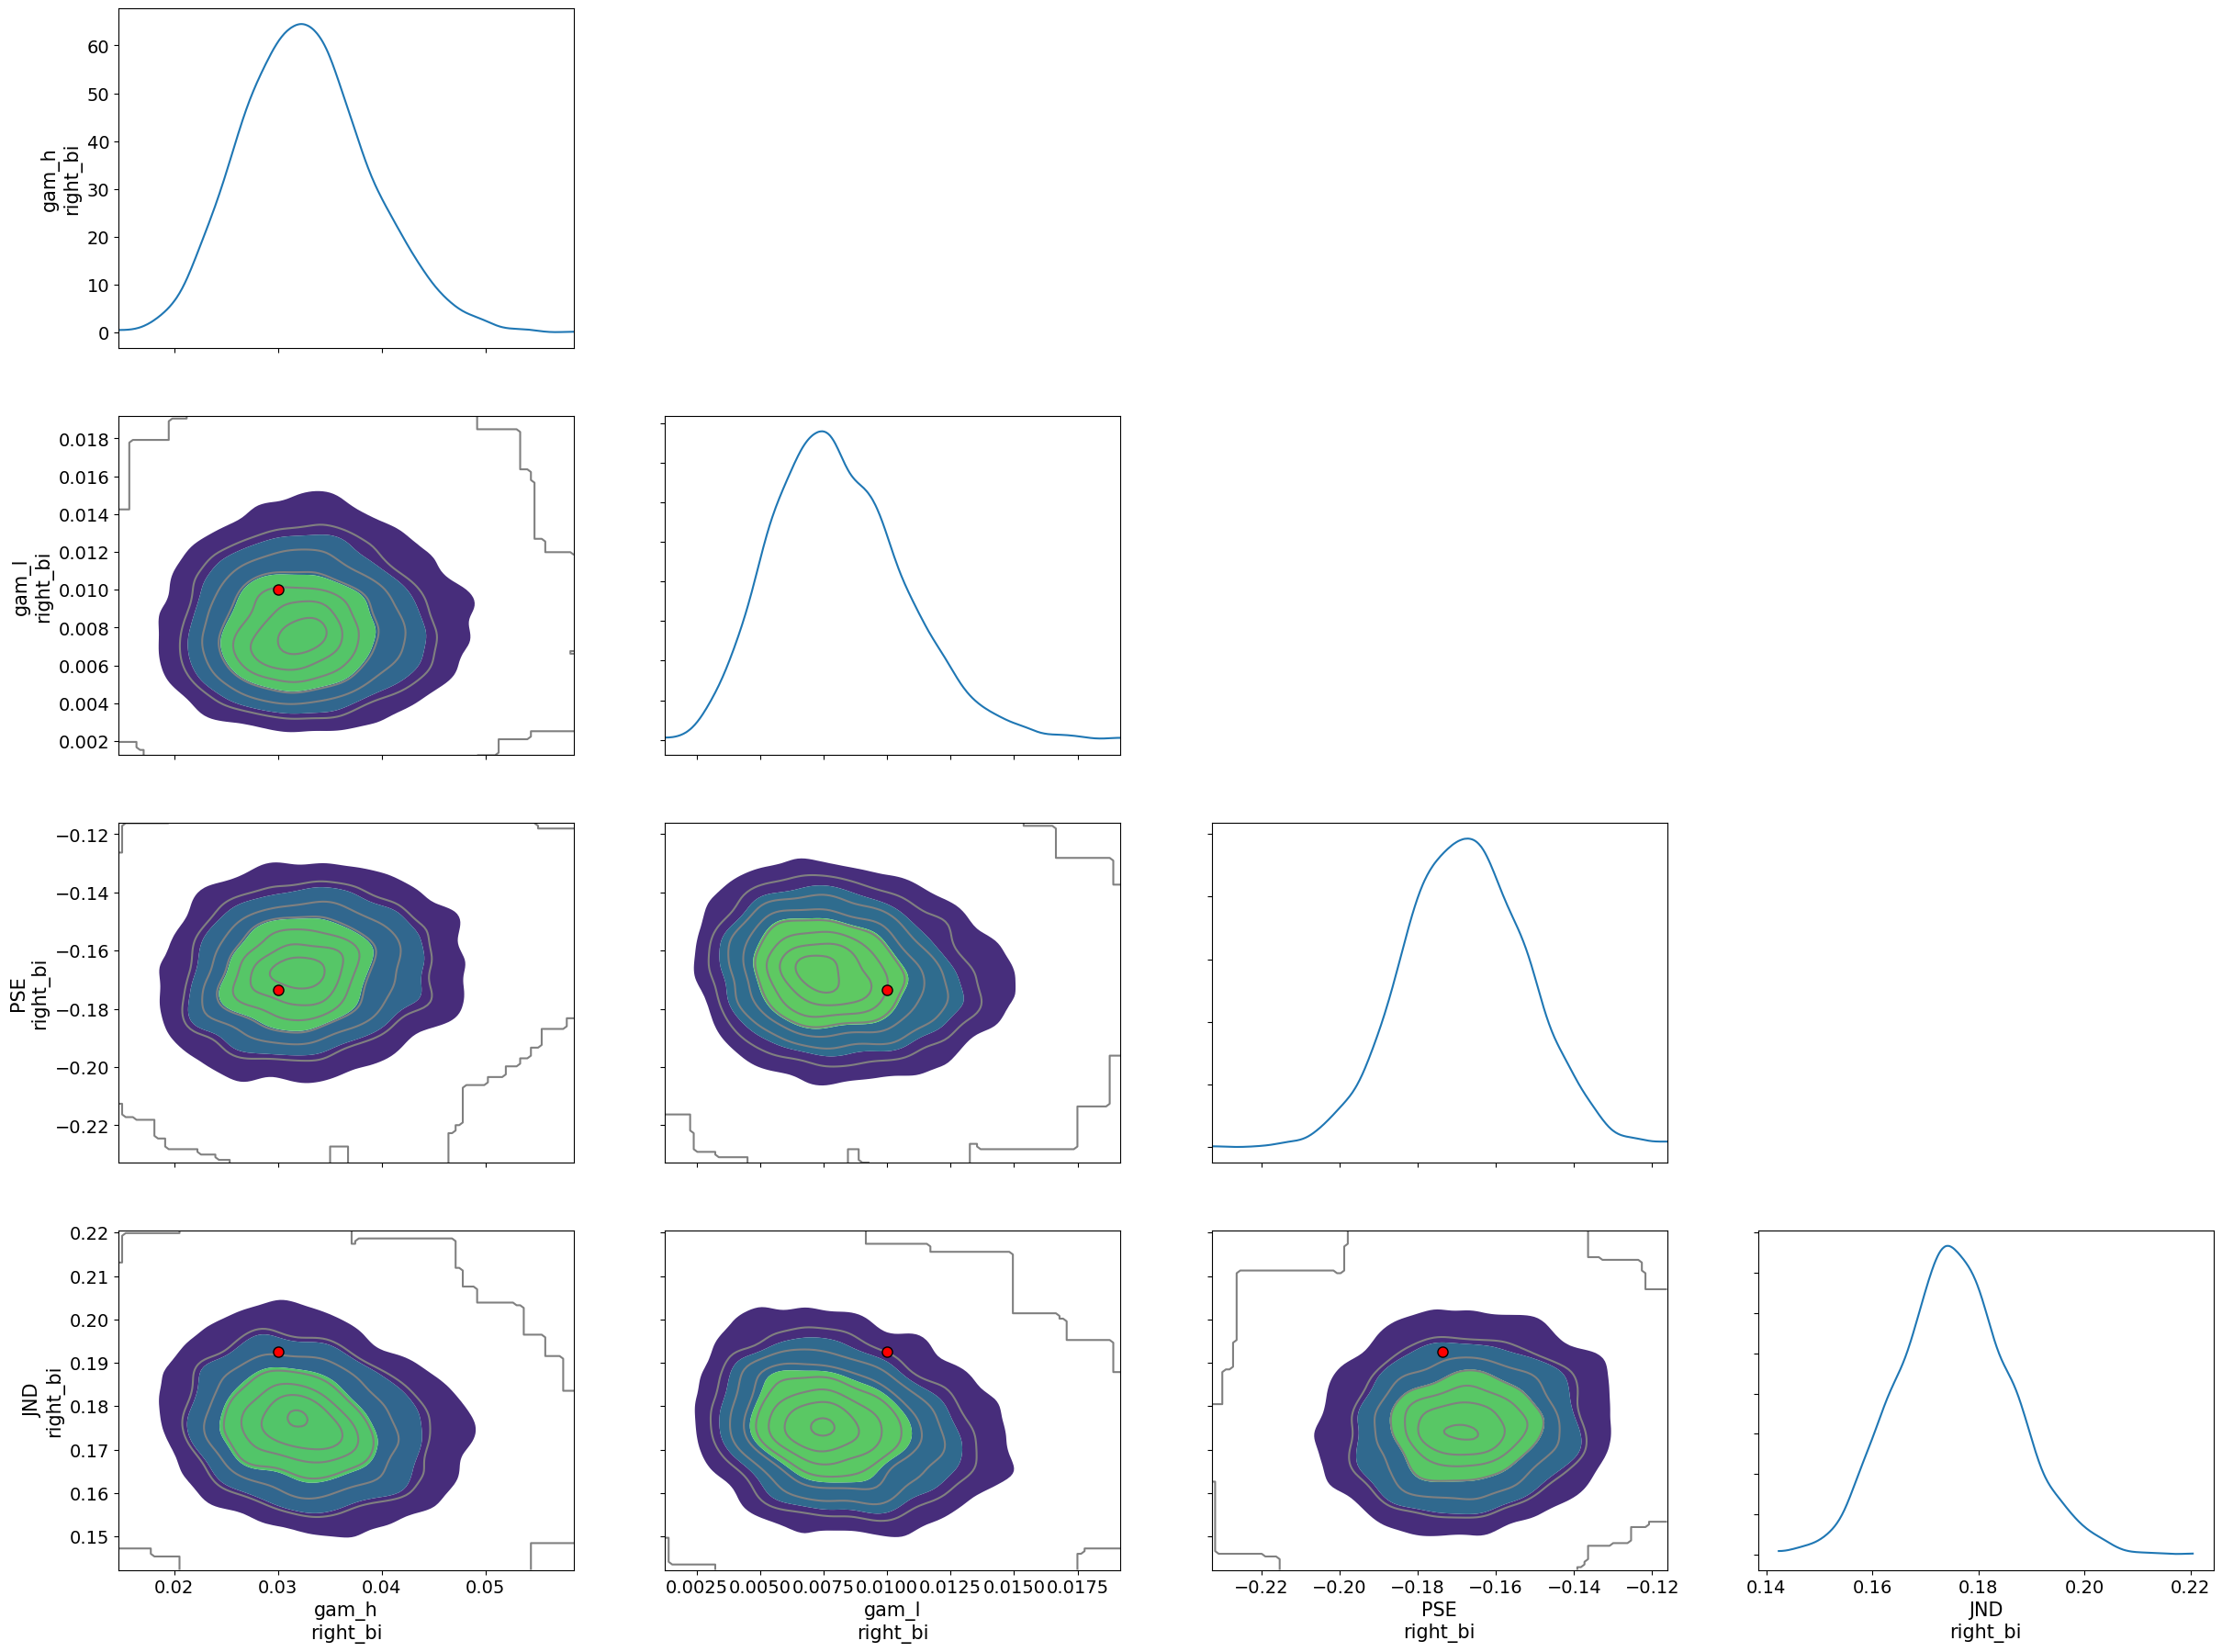

In [9]:

param_bases2 = ['gam_h ', 'gam_l ']
ref_vals2 = {}

for grp_num, grp_choice in enumerate(coords['groups']):
    temp_dict = {}
    for par_num, par_base in enumerate(param_bases2):
        temp_dict[par_base+grp_choice] = params_fixed[par_num][grp_num]
    ref_vals2[grp_choice] = temp_dict
    PSE = (-params_fixed[2][grp_num] + np.log( (1-2*params_fixed[0][grp_num]) / (1-2*params_fixed[1][grp_num]) ))/ params_fixed[3][grp_num]
    JND = np.log( ((3-4*params_fixed[0][grp_num])*(3-4*params_fixed[1][grp_num])) / 
                 ((1-4*params_fixed[0][grp_num])*(1-4*params_fixed[1][grp_num])) ) / (2*params_fixed[3][grp_num])
    ref_vals2[grp_choice]['PSE '+grp_choice] = PSE
    ref_vals2[grp_choice]['JND '+grp_choice] = JND

for grp_num, grp_choice in enumerate(coords['groups']):
    az.plot_pair(trace, var_names=['gam_h', 'gam_l', 'PSE', 'JND'], 
             coords = {'groups': [grp_choice]},  
             reference_values = ref_vals2[grp_choice],
                       reference_values_kwargs=dict(marker="o", color="red", markersize=8),
             kind = 'kde', marginals=True)

Look at traceplots: everything seems good

array([[<Axes: title={'center': 'gam_h\nleft_uni'}>,
        <Axes: title={'center': 'gam_h\nleft_uni'}>],
       [<Axes: title={'center': 'gam_l\nleft_uni'}>,
        <Axes: title={'center': 'gam_l\nleft_uni'}>],
       [<Axes: title={'center': 'beta_vec\nb0, left_uni'}>,
        <Axes: title={'center': 'beta_vec\nb0, left_uni'}>],
       [<Axes: title={'center': 'beta_vec\nb1, left_uni'}>,
        <Axes: title={'center': 'beta_vec\nb1, left_uni'}>]], dtype=object)

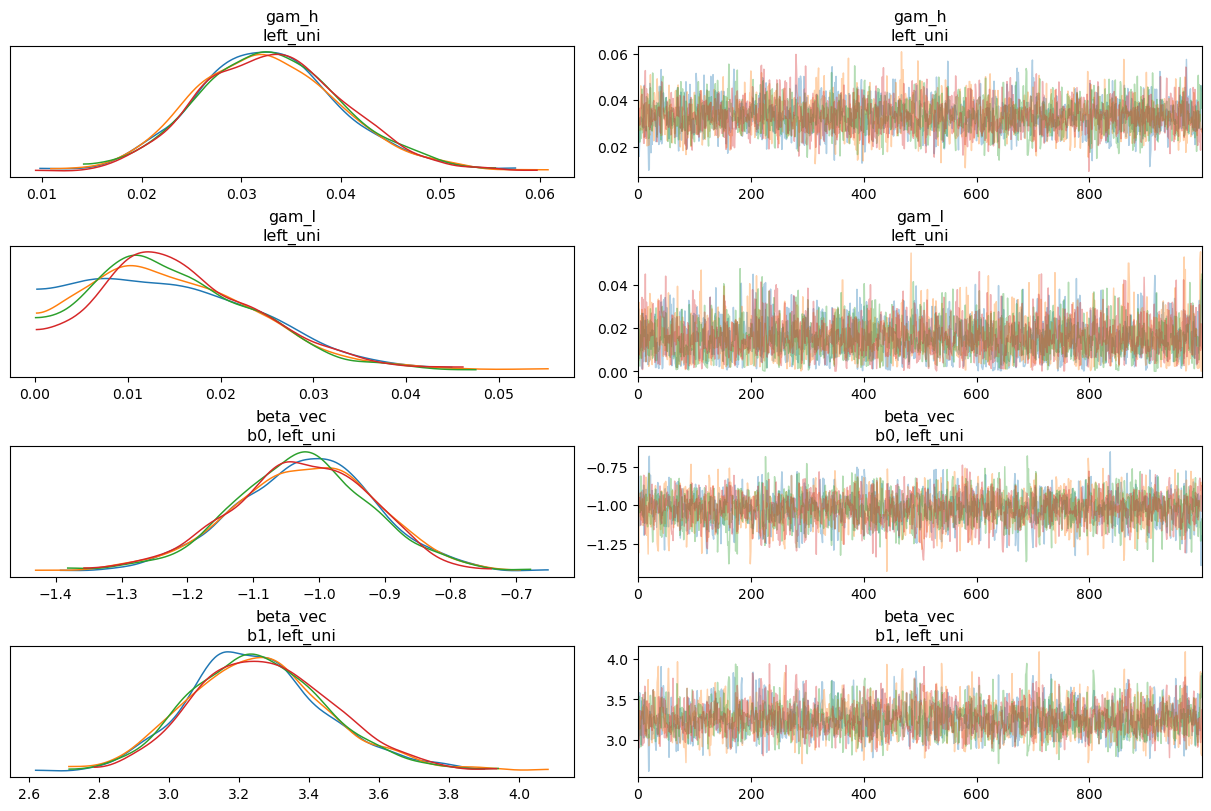

In [30]:
az.plot_trace(trace, var_names=('gam_h', 'gam_l', 'beta_vec'), coords = {
    'groups': ['left_uni'],
    'betas': ["b0", "b1"]}, compact=False,  backend_kwargs={"constrained_layout": True})

In [11]:
param_samps = trace.posterior[['beta_vec', 'gam_h', 'gam_l']]

In [12]:
gam_h_samps = {}
gam_l_samps = {}
beta_0_samps = {}
beta_1_samps = {}


for grp in ["left_bi","left_uni","right_bi","right_uni"]:
    gam_h_samps[grp] = param_samps['gam_h'].sel(groups = grp).values.flatten()
    gam_l_samps[grp] = param_samps['gam_l'].sel(groups = grp).values.flatten()
    beta_0_samps[grp] = param_samps['beta_vec'].sel(groups = grp, betas='b0').values.flatten()
    beta_1_samps[grp] = param_samps['beta_vec'].sel(groups = grp, betas='b1').values.flatten()

In [13]:
def psychfunc(params, X):
    """
    Psychometric function with lapses

    Parameters:
    params : [gamma, lambda_, beta0, beta1]
    X : Stimulus amplitude level

    Returns:
    probability of guess "high"

    """
    X = np.asarray(X)
    gam_h, gam_l, beta0, beta1 = params
    logistic = 1 / (1 + np.exp(-(beta0 + beta1 * X)))
    return gam_h + (1 - gam_h - gam_l) * logistic

In [14]:
#frquencies for each level
freq_df = pd.DataFrame({'stim': cov_mat[:,1], 'grp_idx': grp_idx, 'obs_data': obs_data})
freqs = pd.pivot_table(
    freq_df, 
    values='obs_data',
    index='stim',
    columns='grp_idx',
    aggfunc='mean'
)

C:\Users\schro\AppData\Local\Temp\ipykernel_9168\1121155520.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)


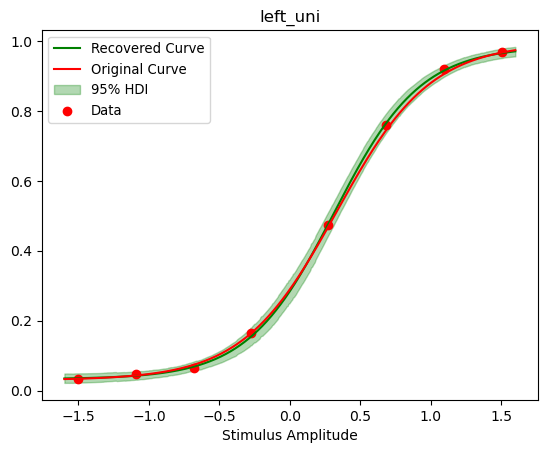

C:\Users\schro\AppData\Local\Temp\ipykernel_9168\1121155520.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)


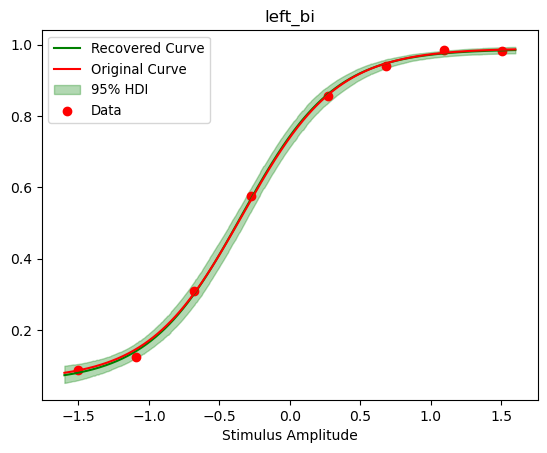

C:\Users\schro\AppData\Local\Temp\ipykernel_9168\1121155520.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)


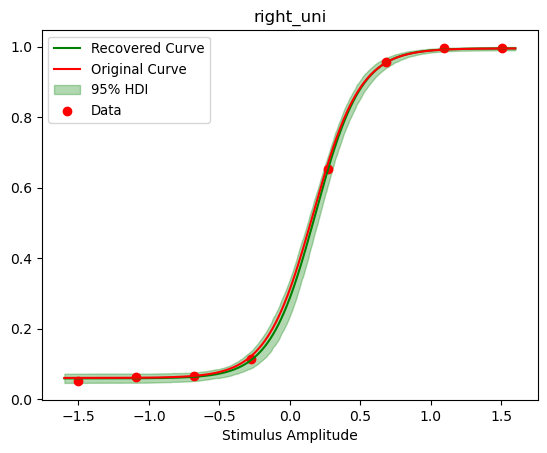

C:\Users\schro\AppData\Local\Temp\ipykernel_9168\1121155520.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)


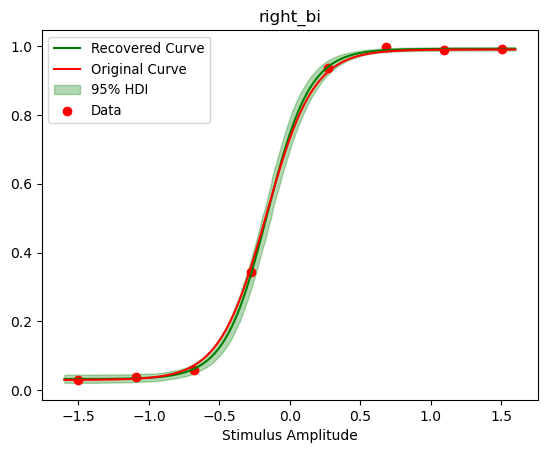

In [15]:
xfit = np.linspace(-1.6,1.6,500)
y_samples = {}
hdis = {}
rec_params = {}
yrec = {}
fixed = np.array(params_fixed)

for grp_i, grp in enumerate(['left_uni','left_bi','right_uni','right_bi']):
    y_samples[grp] = np.array([psychfunc([gam_h,gam_l,beta_0,beta_1], xfit) 
                          for gam_h,gam_l,beta_0,beta_1 in zip(
                              gam_h_samps[grp], gam_l_samps[grp], beta_0_samps[grp], beta_1_samps[grp])])
    hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)
    rec_params[grp] = np.mean(np.array([gam_h_samps[grp], gam_l_samps[grp], beta_0_samps[grp], beta_1_samps[grp]]), axis = 1)
    
    
    yrec[grp] = psychfunc(rec_params[grp], xfit)
    
    plt.plot(xfit,yrec[grp],label='Recovered Curve',color='green')
    plt.plot(xfit, psychfunc(fixed[:,grp_i], xfit), label='Original Curve',color='red')
    plt.fill_between(xfit, hdis[grp][:, 0], hdis[grp][:, 1], color='green', alpha=0.3, label='95% HDI')
    plt.scatter(np.array(freqs.index),np.array(freqs[grp_i]),label='Data', color = 'red')
    plt.title(grp)
    plt.xlabel('Stimulus Amplitude')
    plt.legend(loc='upper left', fontsize=9.5)
    plt.show()   

In [16]:
with model_A:
    pm.sample_posterior_predictive(trace,extend_inferencedata=True)

█

Sampling: [resp]


 |████████████████████| 100.00% [4000/4000 00:02<00:00]

<Axes: xlabel='resp'>

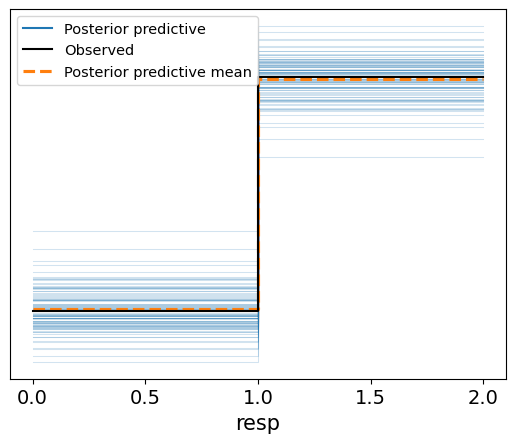

In [17]:
az.plot_ppc(trace, num_pp_samples=100)

In [18]:
true_probs = np.zeros([8,4])
pred_probs = np.zeros([8,4])
fixed = np.array(params_fixed)
for grp_i, grp in enumerate(['left_uni','left_bi','right_uni','right_bi']):
    true_probs[:,grp_i] = psychfunc(fixed[:,grp_i],np.array(freqs.index))
    pred_probs[:,grp_i] = psychfunc(rec_params[grp],np.array(freqs.index))

In [19]:
true_prop = np.array(freqs)

We can see that the model does a better job recovering the original response probabilities than the frequencies of the data.

In [20]:
for i, xi in enumerate(freqs.index):
    for grp_i, grp in enumerate(['left_uni','left_bi','right_uni','right_bi']):
        mask = (np.round(freq_df['stim'],4) == np.round(xi,4)) & (freq_df['grp_idx'] == grp_i)
        freq_df.loc[mask, 'true_prob'] = true_probs[i, grp_i]
        freq_df.loc[mask, 'pred_prob'] = pred_probs[i, grp_i]
        freq_df.loc[mask, 'true_prop'] = true_prop[i, grp_i]

In [21]:
RMSE = np.sqrt(np.mean(np.array(freq_df['pred_prob']-freq_df['true_prob'])**2))
print(RMSE)

0.007871837177214654


In [22]:
np.sqrt(np.mean(np.array(freq_df['true_prop']-freq_df['true_prob'])**2))

0.009028547064225059

In [23]:
az.loo(trace)

Computed from 4000 posterior samples and 12937 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3622.15    66.83
p_loo       14.83        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     12937  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [24]:
with model_A:
    prior = pm.sample_prior_predictive(samples=1000)
trace.extend(prior)

Sampling: [resp, z_beta, z_gam_h, z_gam_l]


array([[<Axes: >, <Axes: >, <Axes: xlabel='gam_l\nleft_uni'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='gam_l\nleft_bi'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='gam_l\nright_uni'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='gam_l\nright_bi'>]],
      dtype=object)

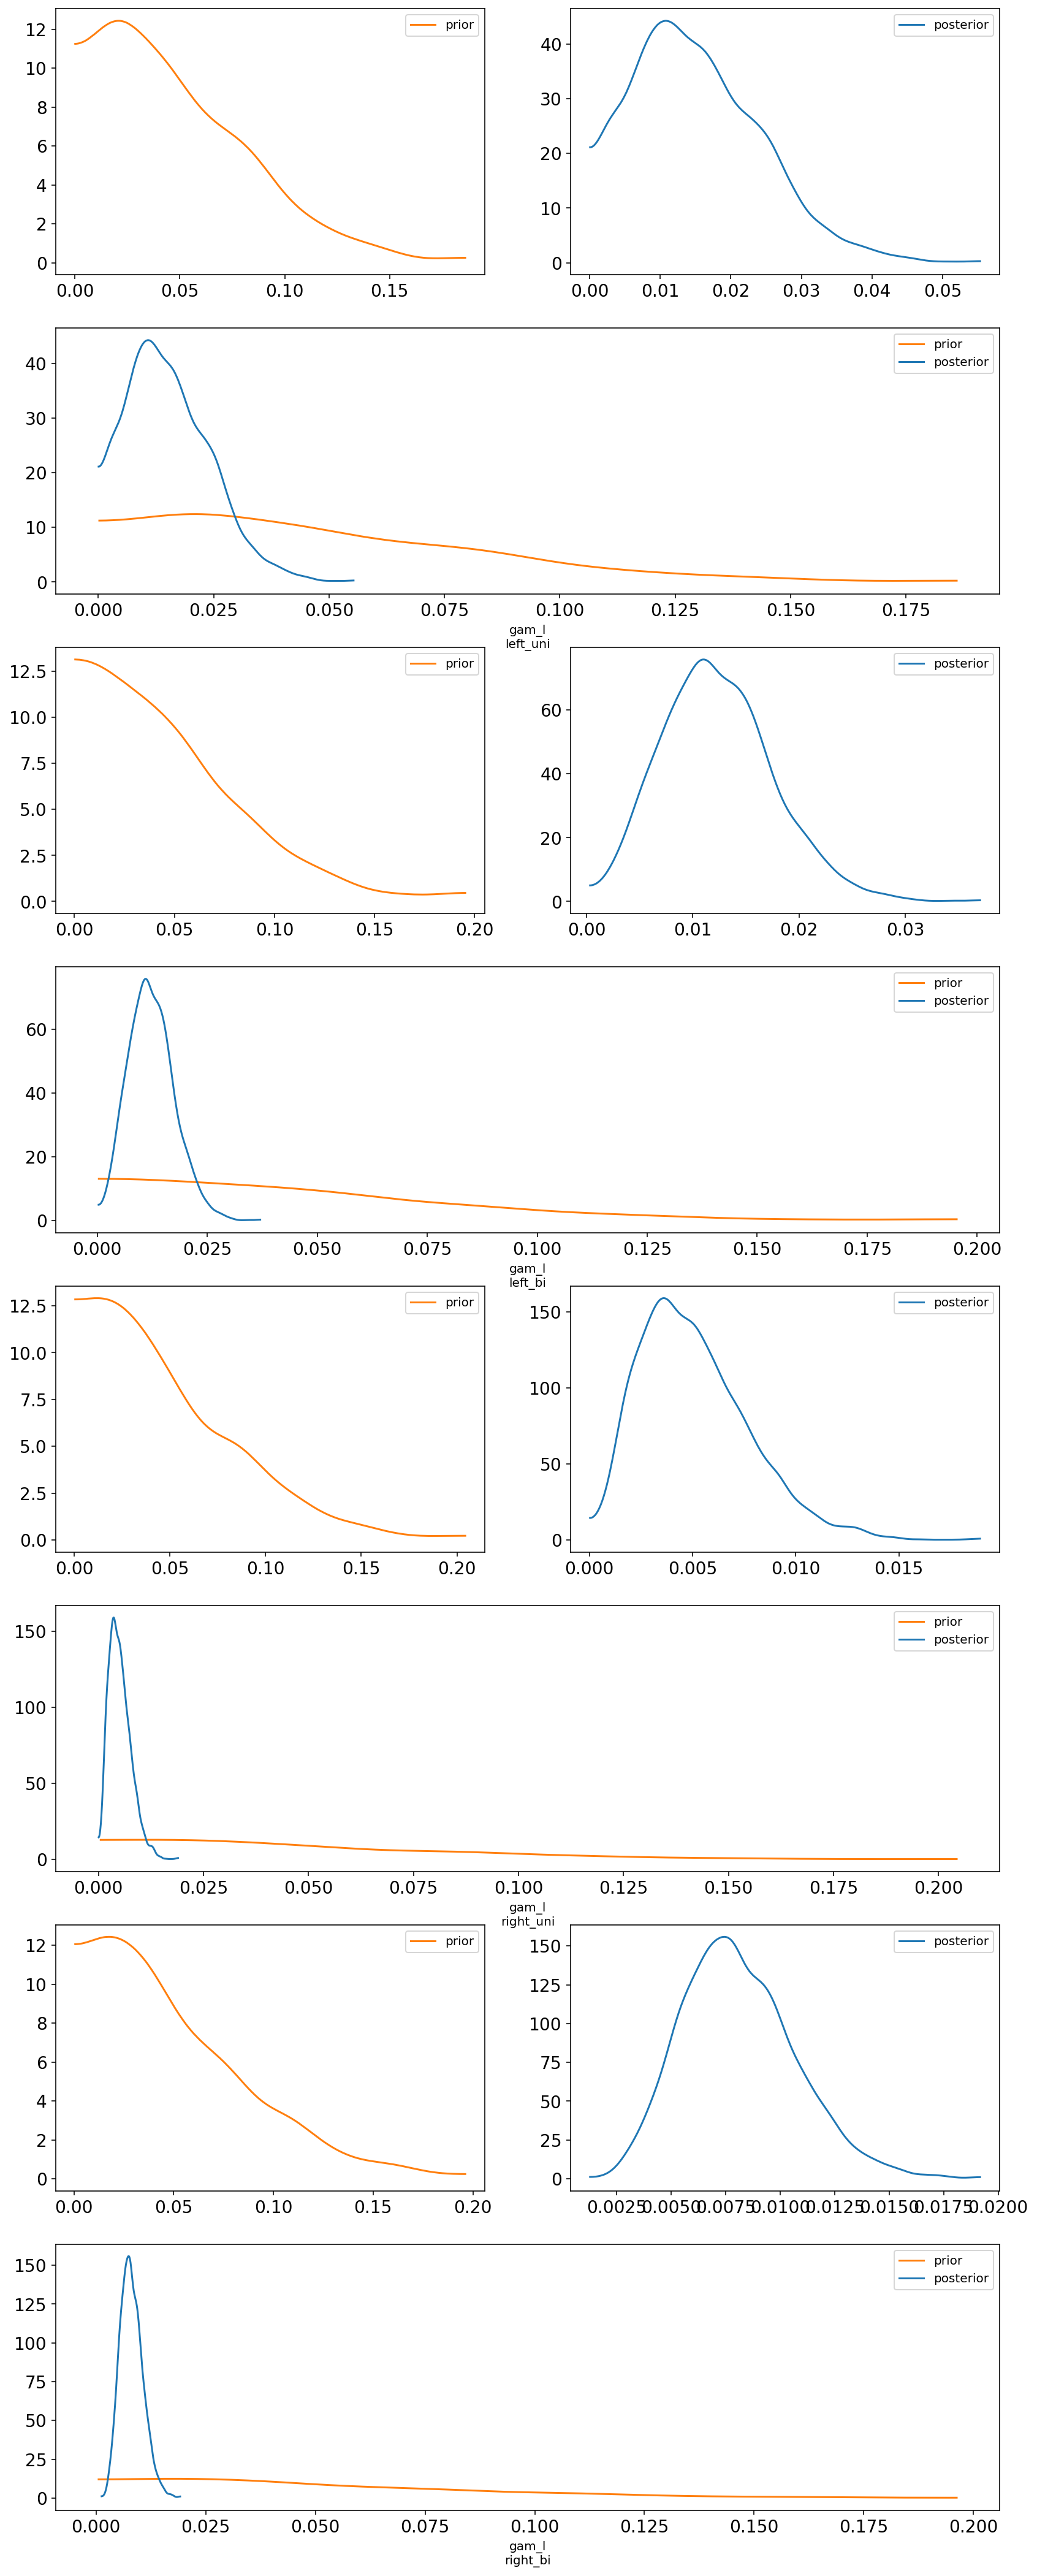

In [31]:
az.plot_dist_comparison(trace, var_names = 'gam_l')

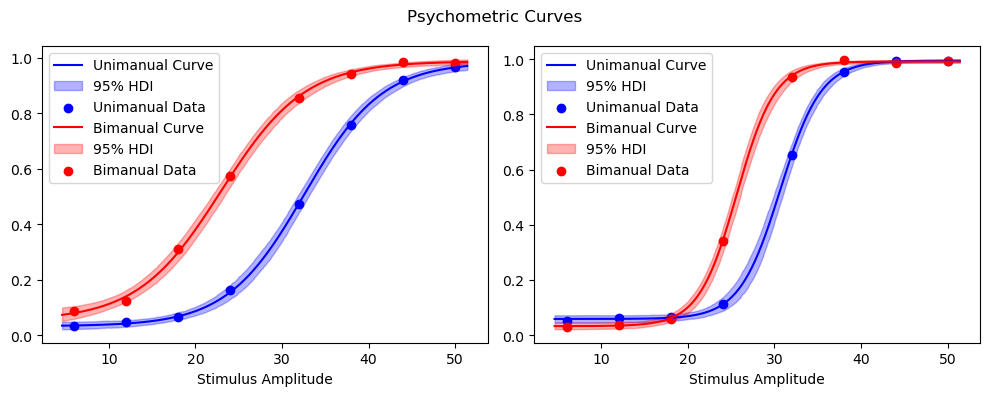

In [29]:
x_old = np.array([6, 12, 18, 24, 32, 38, 44, 50])
x_mu = np.mean(x_old)
x_sig = np.std(x_old)
stims_normed = ((x_old-x_mu)/x_sig)

xfit2 = x_mu+x_sig*xfit



fig, axs = plt.subplots(1, 2, figsize=(10, 4)) # figsize adjusts the figure size

# Plot on the first subplot


axs[0].plot(x_mu+x_sig*xfit,yrec['left_uni'],label='Unimanual Curve',color='blue')
axs[0].fill_between(x_mu+x_sig*xfit, hdis['left_uni'][:, 0], hdis['left_uni'][:, 1], color='blue', alpha=0.3, label='95% HDI')
axs[0].scatter(x_mu+x_sig*np.array(freqs.index),np.array(freqs[0]),label='Unimanual Data', color = 'blue')

axs[0].plot(x_mu+x_sig*xfit,yrec['left_bi'],label='Bimanual Curve',color='red')
axs[0].fill_between(x_mu+x_sig*xfit, hdis['left_bi'][:, 0], hdis['left_bi'][:, 1], color='red', alpha=0.3, label='95% HDI')
axs[0].scatter(x_mu+x_sig*np.array(freqs.index),np.array(freqs[1]),label='Bimanual Data', color = 'red')

axs[0].set_xlabel('Stimulus Amplitude')

axs[1].plot(x_mu+x_sig*xfit,yrec['right_uni'],label='Unimanual Curve',color='blue')
axs[1].fill_between(x_mu+x_sig*xfit, hdis['right_uni'][:, 0], hdis['right_uni'][:, 1], color='blue', alpha=0.3, label='95% HDI')
axs[1].scatter(x_mu+x_sig*np.array(freqs.index),np.array(freqs[2]),label='Unimanual Data', color = 'blue')

axs[1].plot(x_mu+x_sig*xfit,yrec['right_bi'],label='Bimanual Curve',color='red')
axs[1].fill_between(x_mu+x_sig*xfit, hdis['right_bi'][:, 0], hdis['right_bi'][:, 1], color='red', alpha=0.3, label='95% HDI')
axs[1].scatter(x_mu+x_sig*np.array(freqs.index),np.array(freqs[3]),label='Bimanual Data', color = 'red')

axs[1].set_xlabel('Stimulus Amplitude')


axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
fig.suptitle('Psychometric Curves')

plt.tight_layout()
# Display the figure
plt.show()



